In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas
from IPython.display import display
from scipy import stats

In [2]:
adult_df = pandas.read_csv("AIF360 Debiasing Algo Analysis - Data Adult.csv")
adult_df = adult_df.set_index("Adult")
compas_df = pandas.read_csv("AIF360 Debiasing Algo Analysis - Data Compas.csv")
compas_df = compas_df.set_index("Compas")
bank_df = pandas.read_csv("AIF360 Debiasing Algo Analysis - Data Bank.csv")
bank_df = bank_df.set_index("Bank")
german_df = pandas.read_csv("AIF360 Debiasing Algo Analysis - Data German.csv")
german_df = german_df.set_index("German")

for df in [adult_df, compas_df, bank_df, german_df]:
    df["False Positive Rate Diff"] = abs(df["False Positive Rate - Unprivileged"] - df["False Positive Rate - Privileged"])
    df["False Negative Rate Diff"] = abs(df["False Negative Rate - Unprivileged"] - df["False Negative Rate - Privileged"])
    df["Accuracy Diff"] = abs(df["Accuracy - Unprivileged"] - df["Accuracy - Privileged"])
    df["False Omission Rate Diff"] = abs(df["False Omission Rate - Unprivileged"] - df["False Omission Rate - Privileged"])
    df["False Discovery Rate Diff"] = abs(df["False Discovery Rate - Unprivileged"] - df["False Discovery Rate - Privileged"])
    df["Statistical Parity Diff"] = abs(df["Base Rate - Unprivileged"] - df["Base Rate - Privileged"])
    df["F1 Score Diff"] = abs(df["F1 Score - Unprivileged"] - df["F1 Score - Privileged"])

In [3]:
def num_interventions(name):
    if name == "Logistic Regression" or name  == "Meta Classifier":
        return 0
    if name.count('+') == 0:
        return 1
    if name.count('+') == 1:
        return 2
    if name.count('+') == 2:
        return 3

In [4]:
no_int = []
one_int = []
two_int = []
three_int = []
print(adult_df.index)
for row in list(adult_df.index):
    if num_interventions(row) == 0:
        no_int.append(row)
    elif num_interventions(row) == 1:
        one_int.append(row)
    elif num_interventions(row) == 2:
        two_int.append(row)
    elif num_interventions(row) == 3:
        three_int.append(row)
        
print(no_int)
print(one_int)
print(two_int)
print(three_int)

Index(['Logistic Regression', 'RW', 'DIR', 'EGR', 'GSR', 'PR', 'CEOP', 'ROC',
       'EOP', 'RW + EGR', 'RW + GSR', 'RW + PR', 'RW + CEOP', 'RW + ROC',
       'RW + EOP', 'DIR + EGR', 'DIR + GSR', 'DIR + PR', 'DIR + CEOP',
       'DIR + ROC', 'DIR + EOP', 'EGR + CEOP', 'EGR + ROC', 'EGR + EOP',
       'GSR + CEOP', 'GSR + ROC', 'GSR + EOP', 'PR + CEOP', 'PR + ROC',
       'PR + EOP', 'RW + EGR + CEOP', 'RW + EGR + ROC', 'RW + EGR + EOP',
       'RW + GSR + CEOP', 'RW + GSR + ROC', 'RW + GSR + EOP', 'RW + PR + CEOP',
       'RW + PR + ROC', 'RW + PR + EOP', 'DIR + EGR + CEOP', 'DIR + EGR + ROC',
       'DIR + EGR + EOP', 'DIR + GSR + CEOP', 'DIR + GSR + ROC',
       'DIR + GSR + EOP', 'DIR + PR + CEOP', 'DIR + PR + ROC',
       'DIR + PR + EOP'],
      dtype='object', name='Adult')
['Logistic Regression']
['RW', 'DIR', 'EGR', 'GSR', 'PR', 'CEOP', 'ROC', 'EOP']
['RW + EGR', 'RW + GSR', 'RW + PR', 'RW + CEOP', 'RW + ROC', 'RW + EOP', 'DIR + EGR', 'DIR + GSR', 'DIR + PR', 'DIR + CEOP', 'DI

In [5]:
diff_metrics = [metric for metric in adult_df.columns if "Diff" in metric]
spearman_df = pandas.DataFrame(columns=diff_metrics)

accuracy_lst = np.array([df["Accuracy"].tolist() for df in [adult_df, compas_df, bank_df, german_df]]).flatten()
f1_lst = np.array([df["F1 Score"].tolist() for df in [adult_df, compas_df, bank_df, german_df]]).flatten()

for metric in diff_metrics:
    bias_metric = np.array([df[metric].tolist() for df in [adult_df, compas_df, bank_df, german_df]]).flatten()
    #print(metric, bias_metric)
    spearman_df[metric] = [stats.spearmanr(bias_metric, accuracy_lst)[0], stats.spearmanr(bias_metric, f1_lst)[0]]
spearman_df.index = ["Accuracy", "F1 Score"]
spearman_df

False Positive Rate Diff  False Negative Rate Diff  Accuracy Diff  \
Accuracy                 -0.363237                  0.029029       0.362343   
F1 Score                  0.605588                  0.114367      -0.167700   

          False Omission Rate Diff  False Discovery Rate Diff  \
Accuracy                  0.080447                   0.500010   
F1 Score                 -0.054546                  -0.336535   

          Statistical Parity Diff  F1 Score Diff  
Accuracy                -0.213685       0.036877  
F1 Score                 0.324778      -0.025277

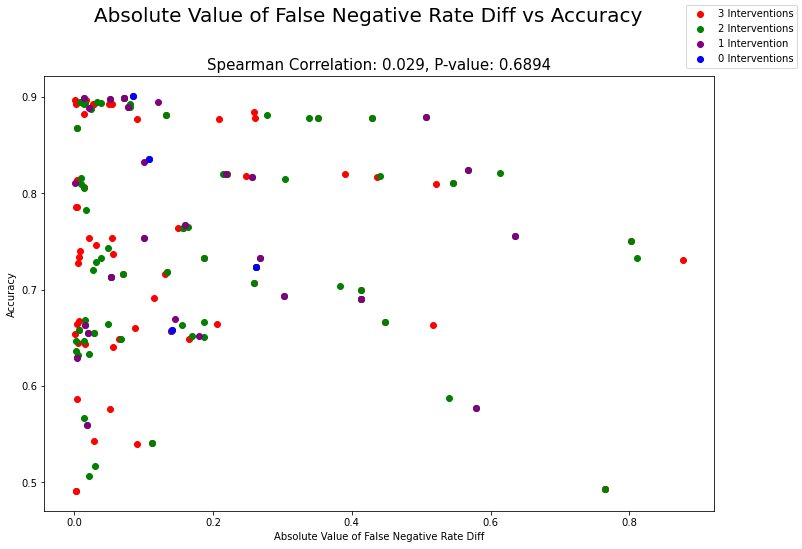

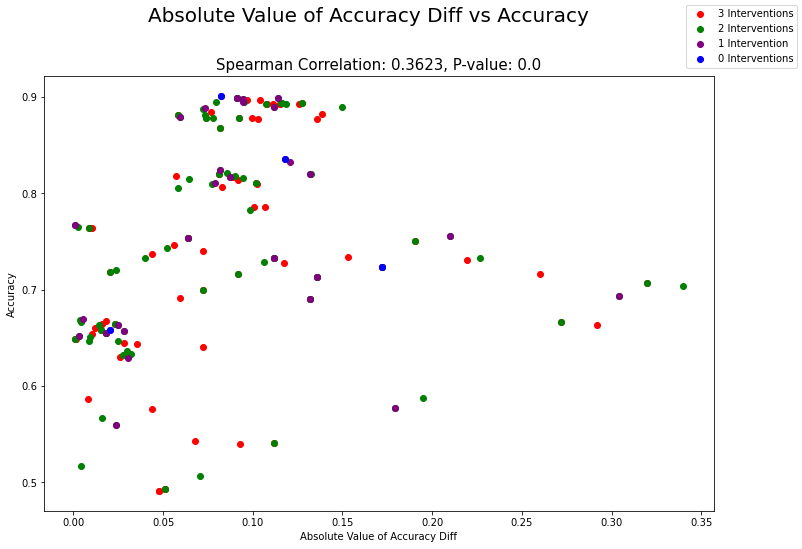

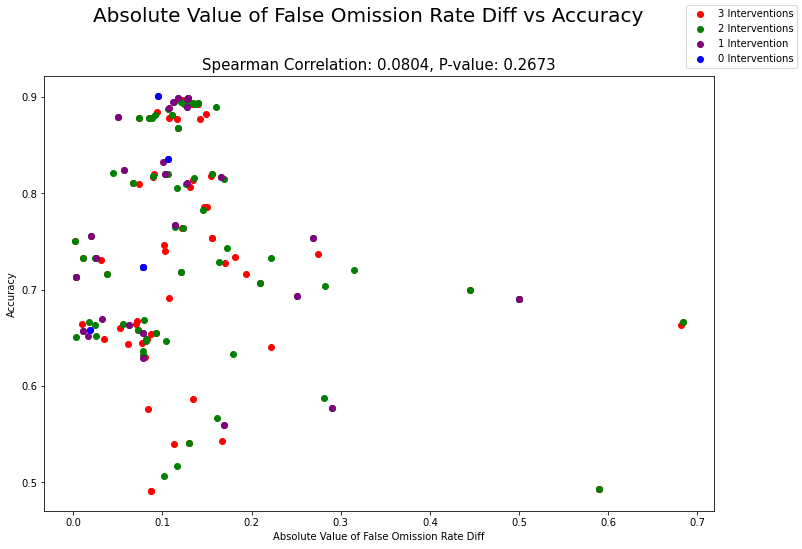

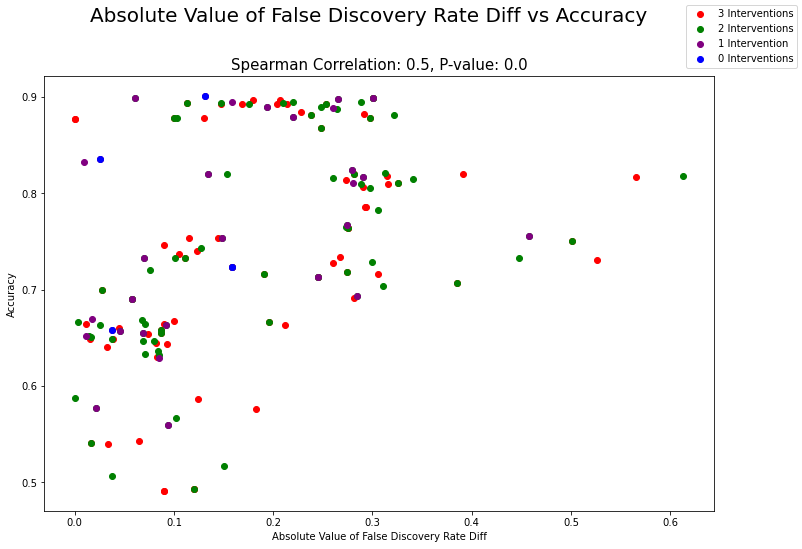

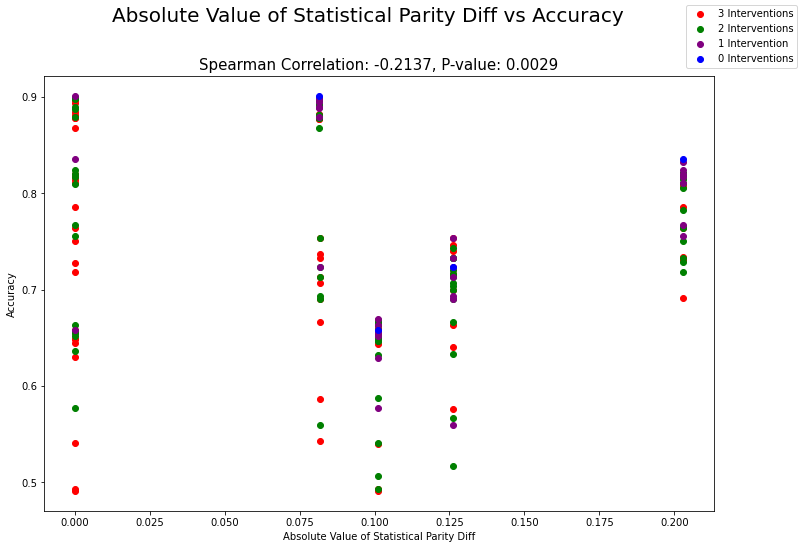

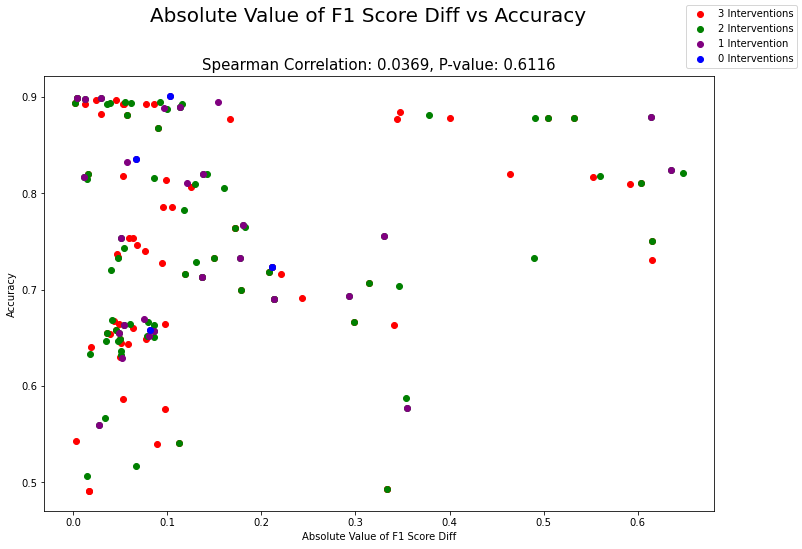

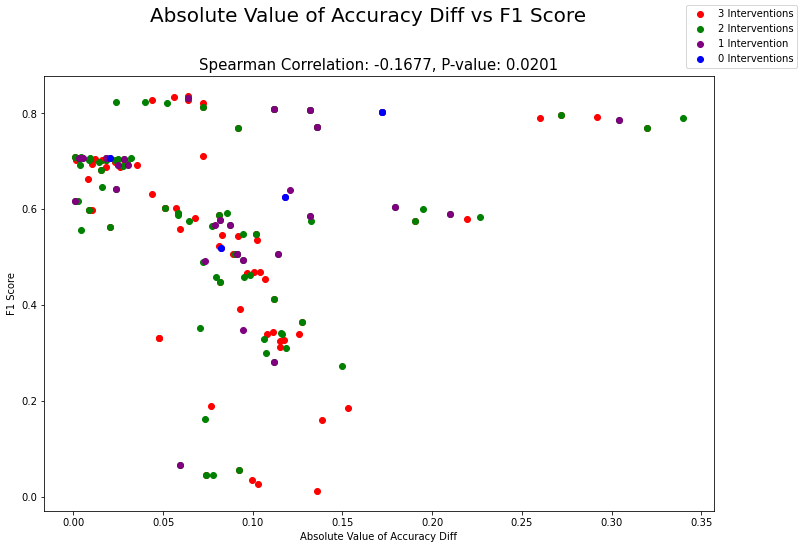

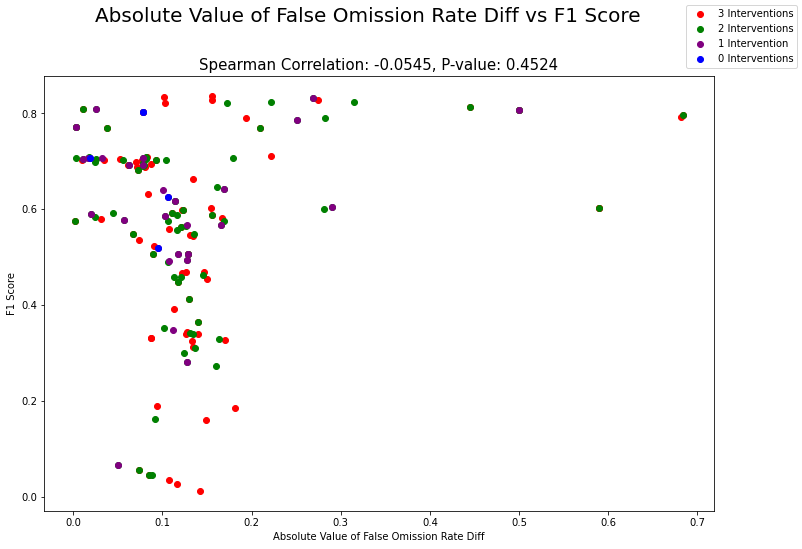

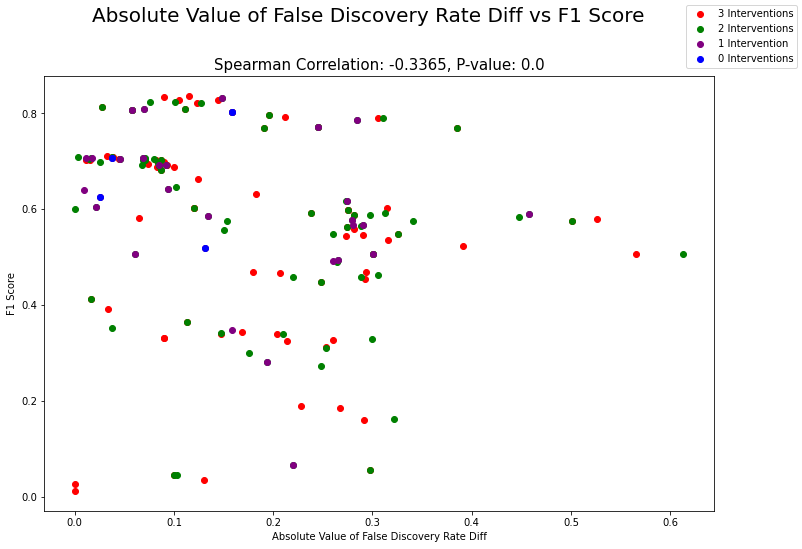

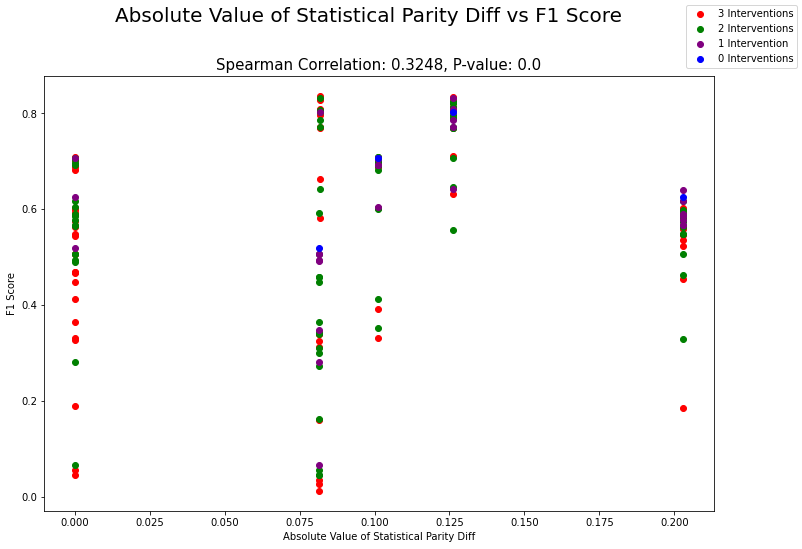

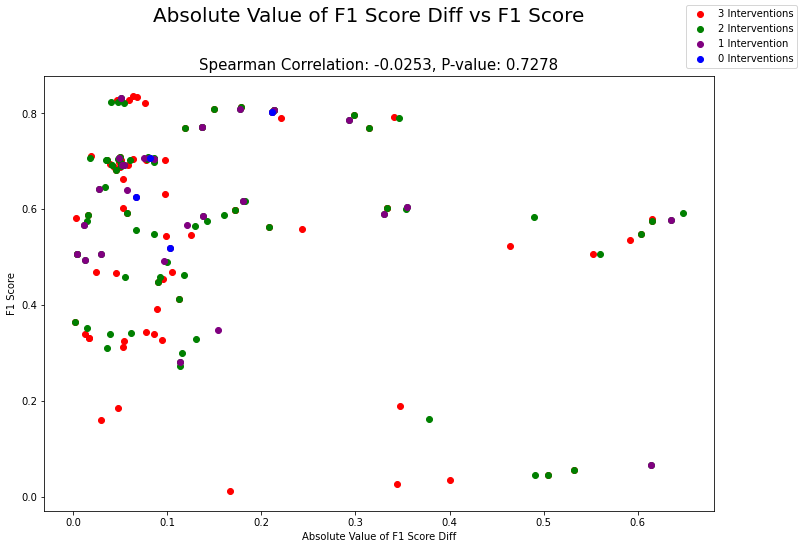

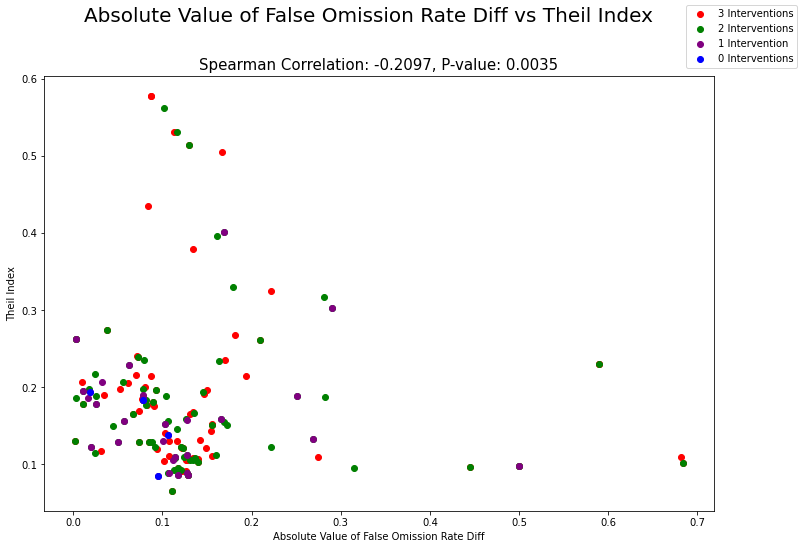

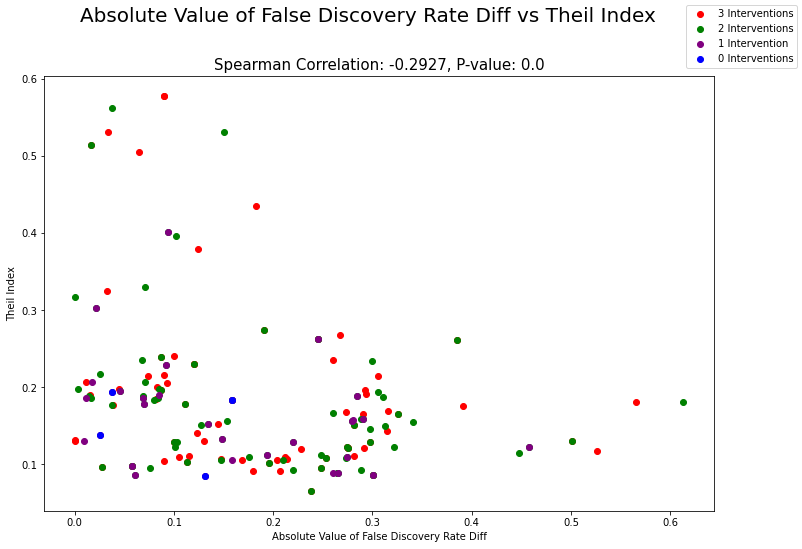

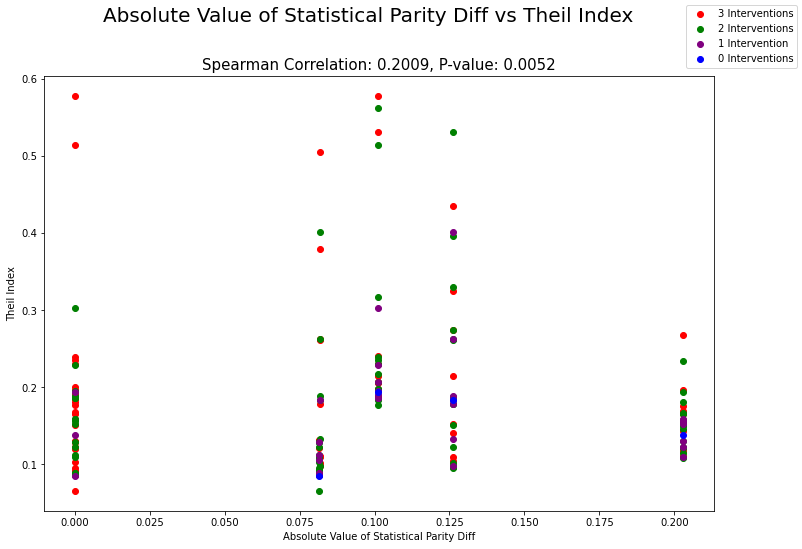

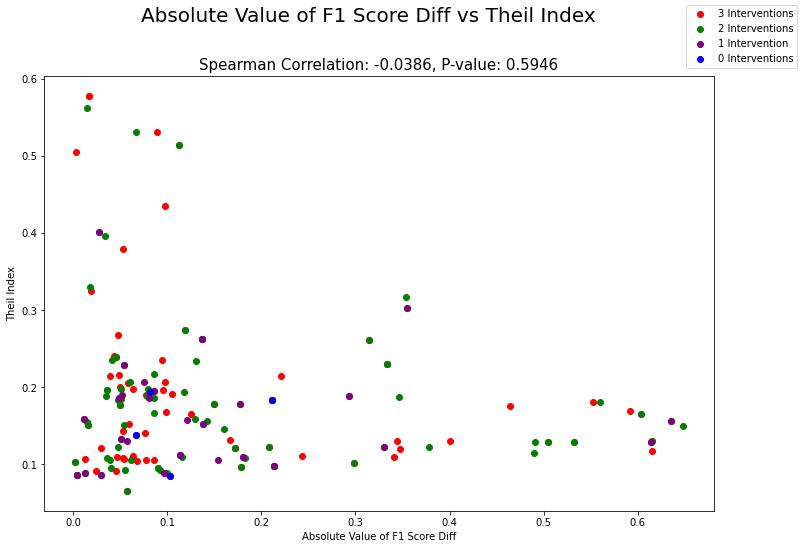

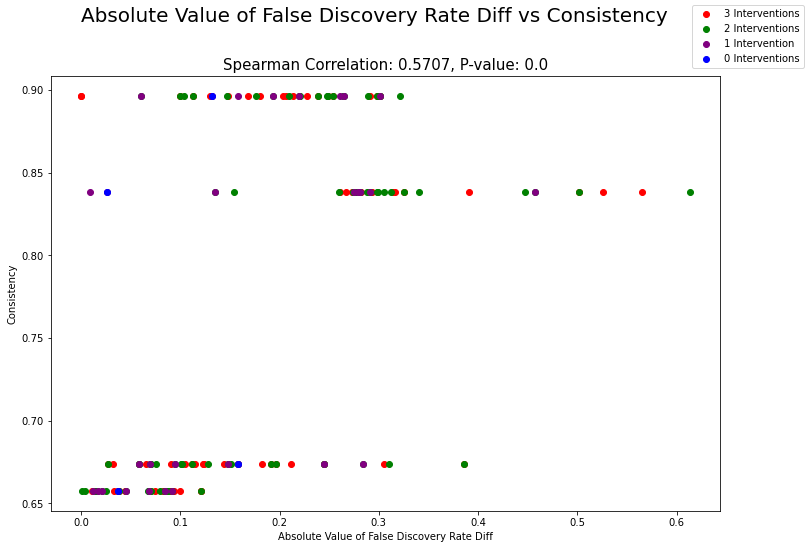

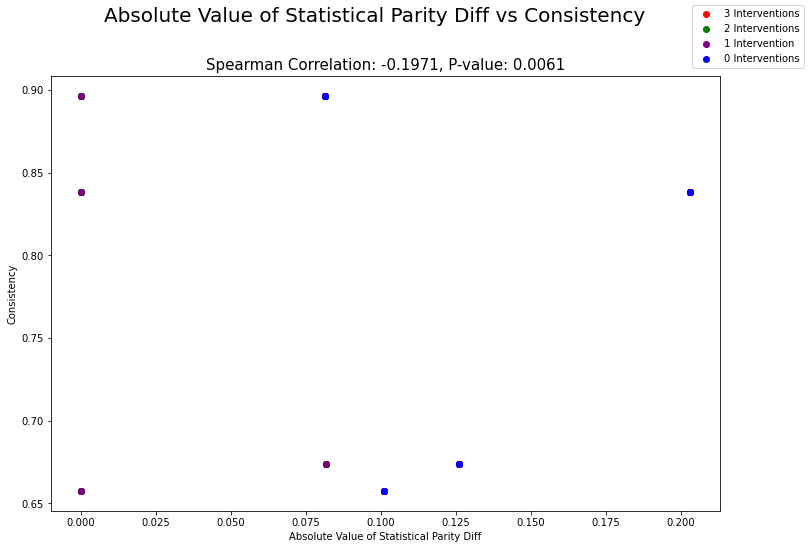

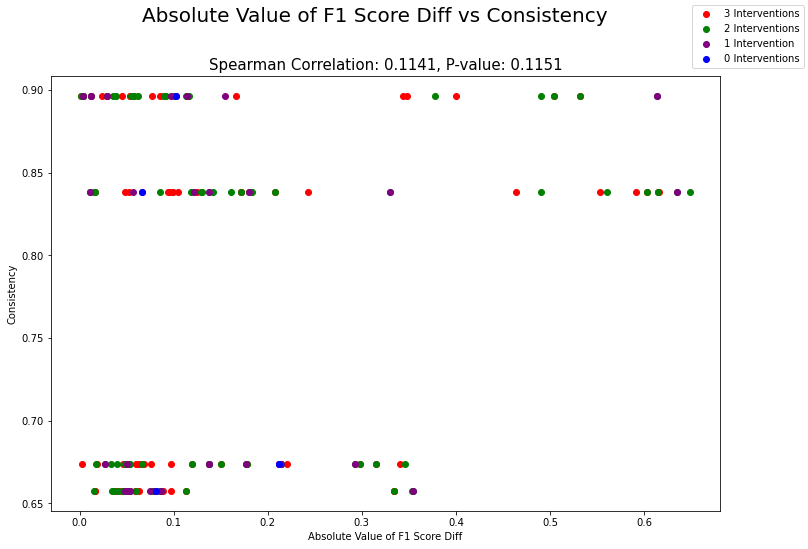

In [6]:
def display_scatter(x, y):
    x_diff = "Diff" in x
    y_diff = "Diff" in y
    
    spearman_x = np.array([])
    spearman_y = np.array([])
    
    fig = plt.figure(figsize=(12, 8))
    
    for df, marker in zip([adult_df, compas_df, bank_df, german_df], ["," , "o" , "v" , "^"]):
        x4 = df.reindex(columns=[x], index=three_int)
        if x_diff:
            x4 = abs(x4)
        y4 = df.reindex(columns=[y], index=three_int)
        if x_diff:
            y4 = abs(y4)
        spearman_x = np.append(spearman_x, x4.to_numpy().flatten())
        spearman_y = np.append(spearman_y, y4.to_numpy().flatten())
        if marker == ",":
            plt.scatter(x4, y4, c ="red", label="3 Interventions")
        else:
            plt.scatter(x4, y4, c ="red",)

    for df, marker in zip([adult_df, compas_df, bank_df, german_df], ["," , "o" , "v" , "^"]):
        x3 = df.reindex(columns=[x], index=two_int)
        if x_diff:
            x3 = abs(x3)
        y3 = df.reindex(columns=[y], index=two_int)
        if y_diff:
            y3 = abs(y3)
        spearman_x = np.append(spearman_x, x3.to_numpy().flatten())
        spearman_y = np.append(spearman_y, y3.to_numpy().flatten())
        if marker == ",":
            plt.scatter(x3, y3, c ="green", label="2 Interventions")
        else:
            plt.scatter(x3, y3, c ="green",)
    
    for df, marker in zip([adult_df, compas_df, bank_df, german_df], ["," , "o" , "v" , "^"]):
        x2 = df.reindex(columns=[x], index=one_int)
        if x_diff:
            x2 = abs(x2)
        y2 = df.reindex(columns=[y], index=one_int)
        if y_diff:
            y2 = abs(y2)
        spearman_x = np.append(spearman_x, x2.to_numpy().flatten())
        spearman_y = np.append(spearman_y, y2.to_numpy().flatten())
        if marker == ",":
            plt.scatter(x2, y2, c ="purple", label="1 Intervention")
        else:
            plt.scatter(x2, y2, c ="purple")
            
    for df, marker in zip([adult_df, compas_df, bank_df, german_df], ["," , "o" , "v" , "^"]):
        x1 = df.reindex(columns=[x], index=no_int)
        if x_diff:
            x1 = abs(x1)
        y1 = df.reindex(columns=[y], index=no_int)
        if y_diff:
            y1 = abs(y1)
        spearman_x = np.append(spearman_x, x1.to_numpy().flatten())
        spearman_y = np.append(spearman_y, y1.to_numpy().flatten())
        if marker == ",":
            plt.scatter(x1, y1, c ="blue", label="0 Interventions",)
        else:
            plt.scatter(x1, y1, c ="blue",)
        #plt.axhline(y = y1.iloc[0,0].item(), color = 'blue', linestyle = 'dashed')
        #plt.axvline(x = x1.iloc[0,0].item(), color = 'blue', linestyle = 'dashed')
    #print(np.array(spearman_x).flatten())
    #print(np.array(spearman_y).flatten())
    
    spearman_corr, spearman_p = stats.spearmanr(spearman_x, spearman_y)
    #print(spearman_corr, spearman_p)

    if x_diff:
        x = "Absolute Value of " + x
    
    if y_diff:
        y = "Absolute Value of " + y
        
    plt.xlabel(x)
    plt.ylabel(y)
    fig.legend()
    fig.set_alpha(1.0)
    fig.patch.set_facecolor('white')
    plt.suptitle(f"{x} vs {y}", y=1, fontsize=20)
    plt.title(f"Spearman Correlation: {round(spearman_corr,4)}, P-value: {round(spearman_p,4)}", fontsize=15)
    #plt.show()
    plt.savefig("R2/" + x + " vs " + y + ".png", bbox_inches='tight', )
    
# cyan: 0 int'
# purple: 1 int'
# green: 2 int'
# red: 3 int'
#display_scatter("False Positive Rate Diff", "F1 Score")
'''for metric1 in range(1, len(adult_df.columns[1:])):
    if "Num" in adult_df.columns[metric1]:
        continue
    for metric2 in range(metric1+1, len(adult_df.columns[1:])):
        if "Num" in adult_df.columns[metric2]:
            continue
        display_scatter(adult_df.columns[metric1], adult_df.columns[metric2])'''
bias_metrics = [metric for metric in adult_df.columns if "Diff" in metric]
util_metrics = ["Accuracy", "F1 Score", "Theil Index", "Consistency"]
for m1 in range(len(util_metrics)):
    for m2 in range(m1+1, len(bias_metrics)):
        display_scatter(bias_metrics[m2], util_metrics[m1])

#display_scatter("Accuracy", "F1 Score")


/Users/mihirmishra/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
<ipython-input-7-699c3293acba>:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(12, 8))


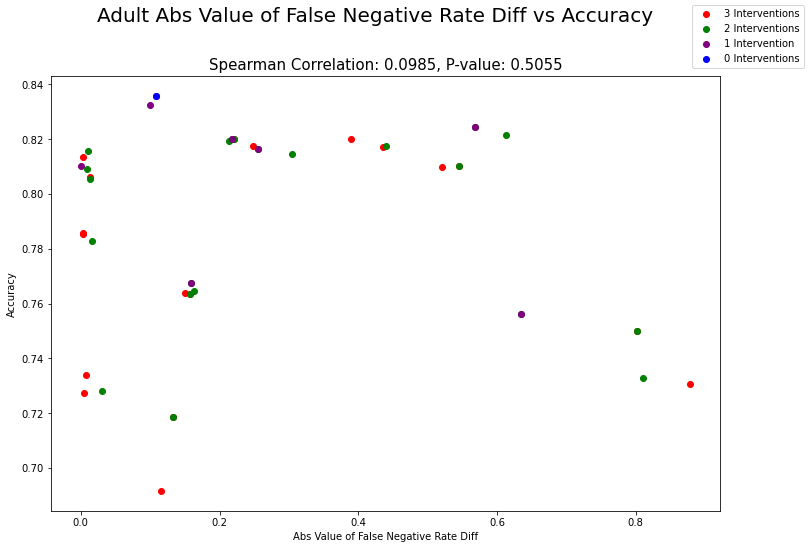

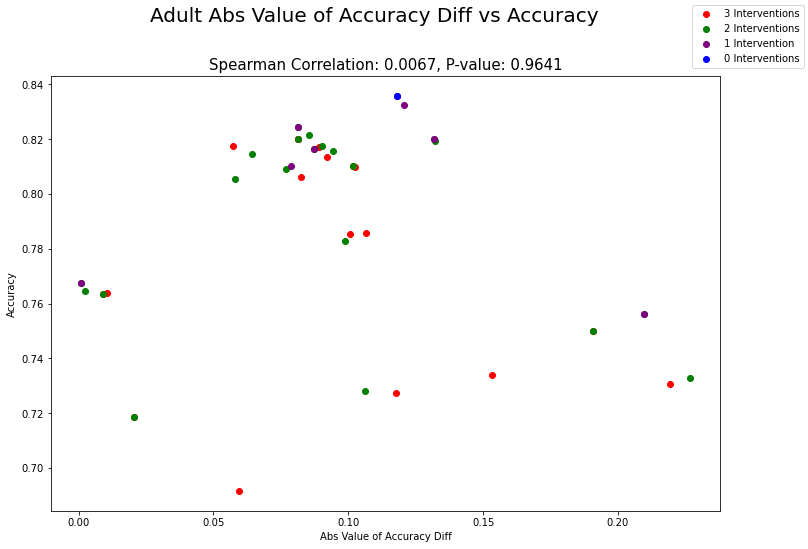

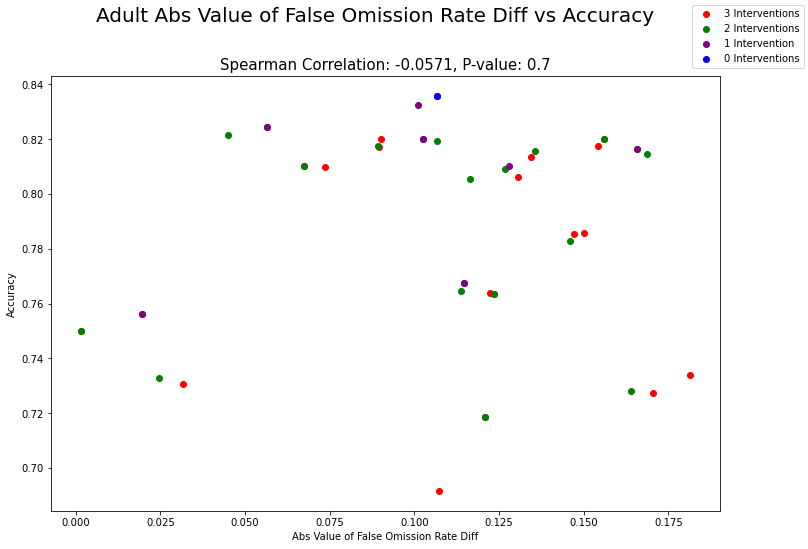

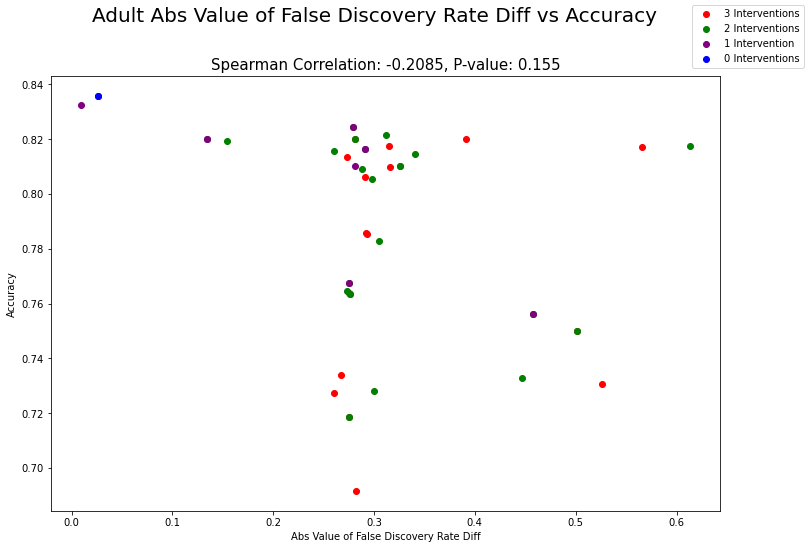

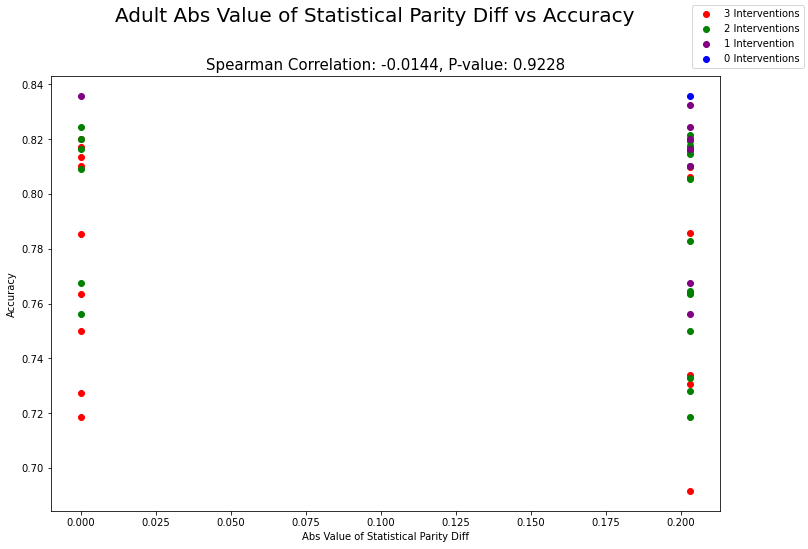

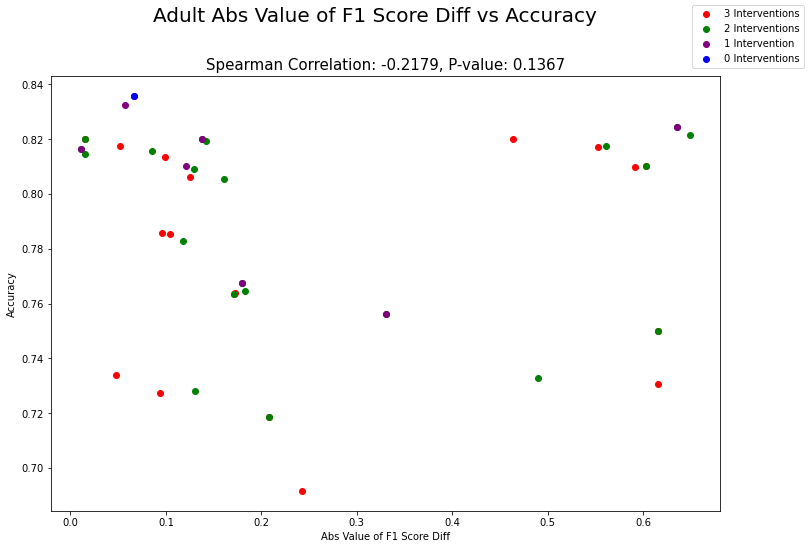

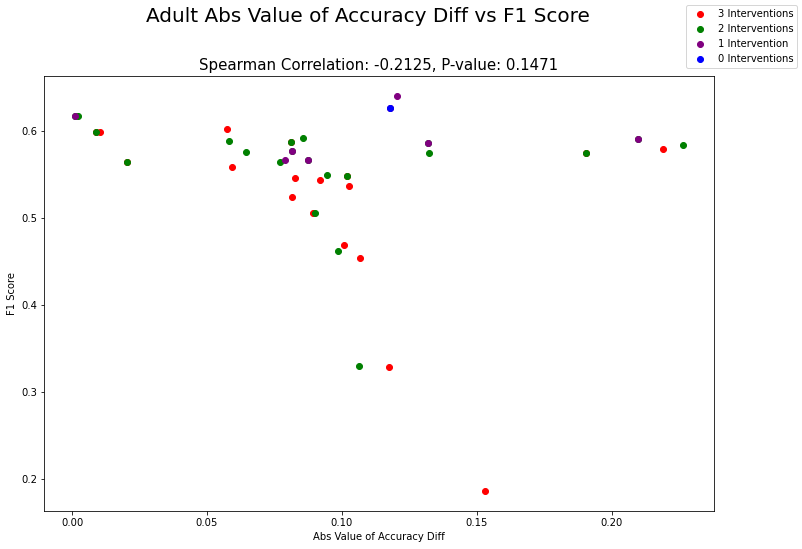

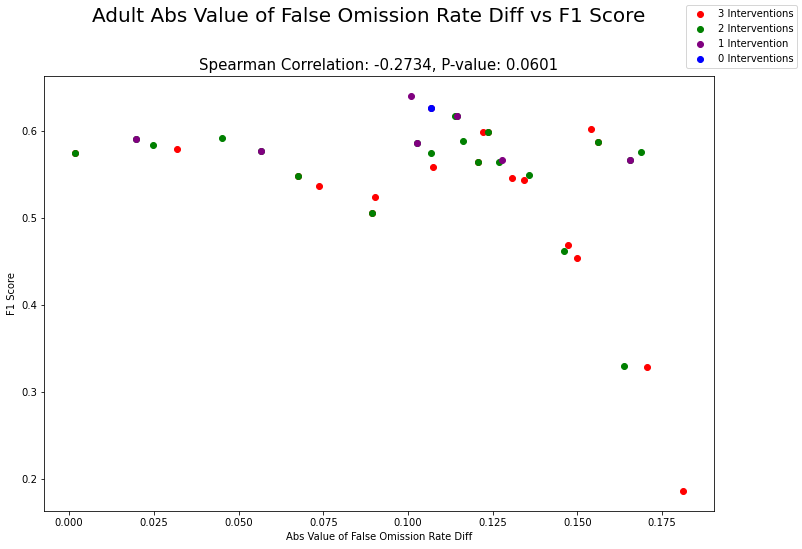

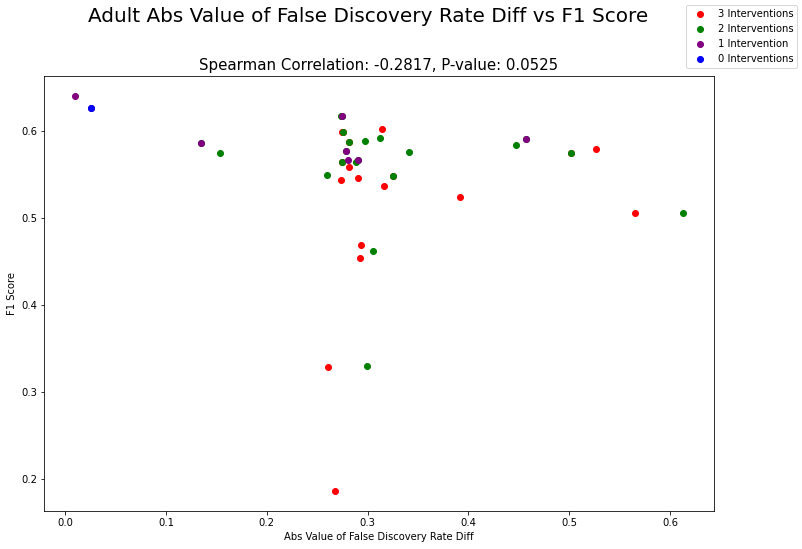

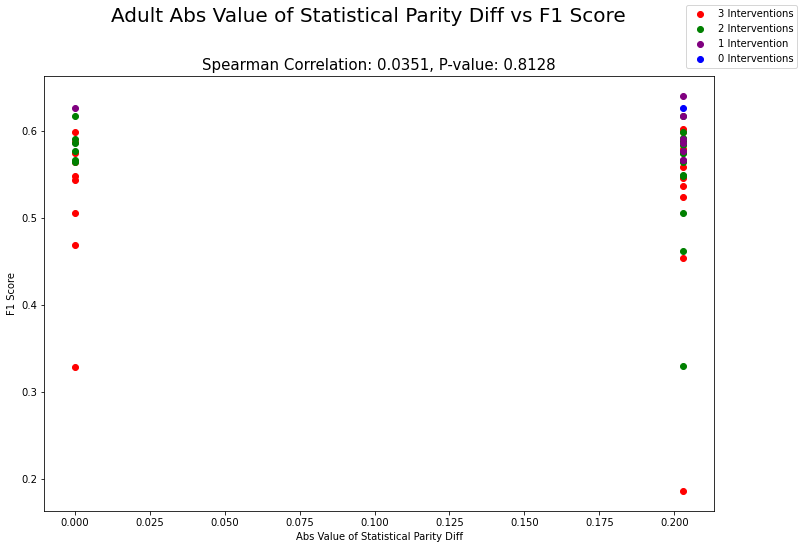

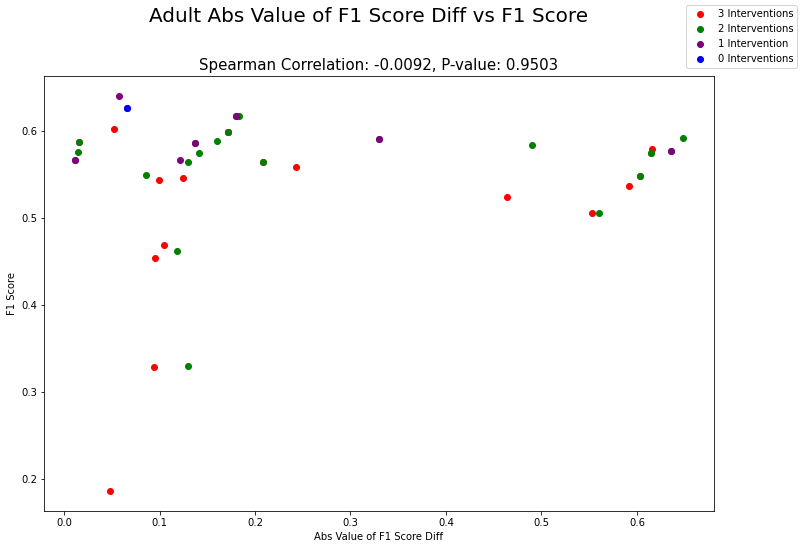

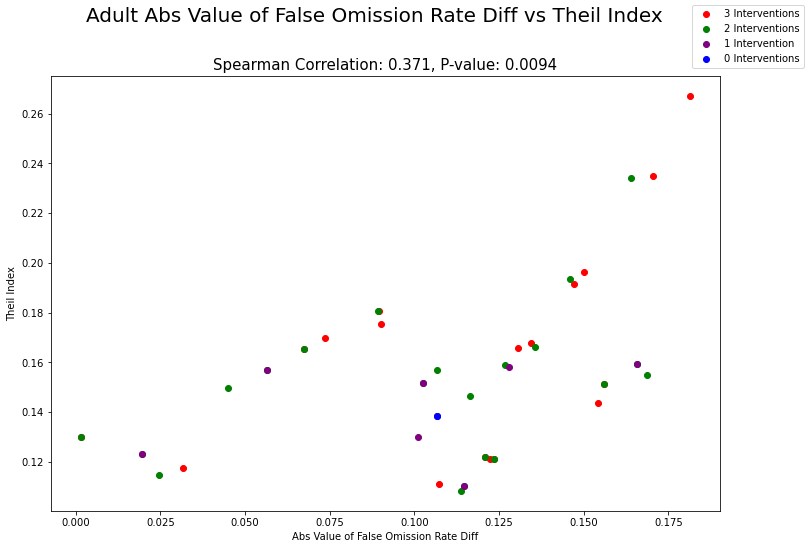

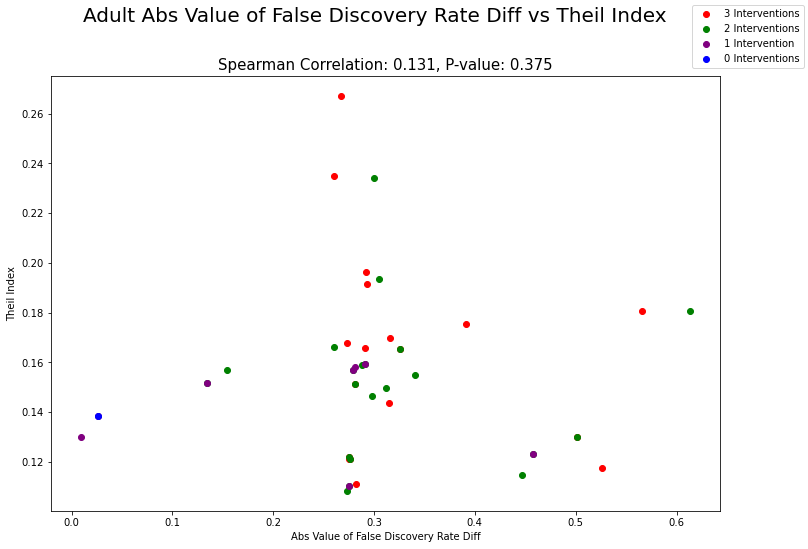

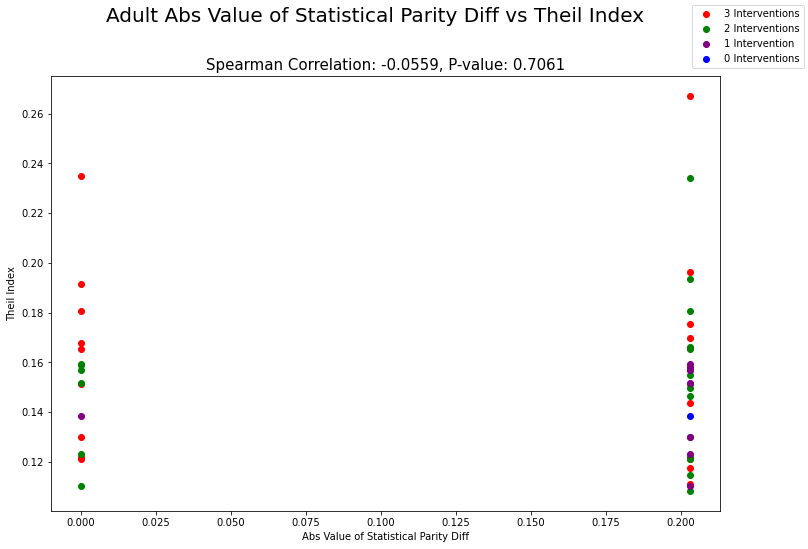

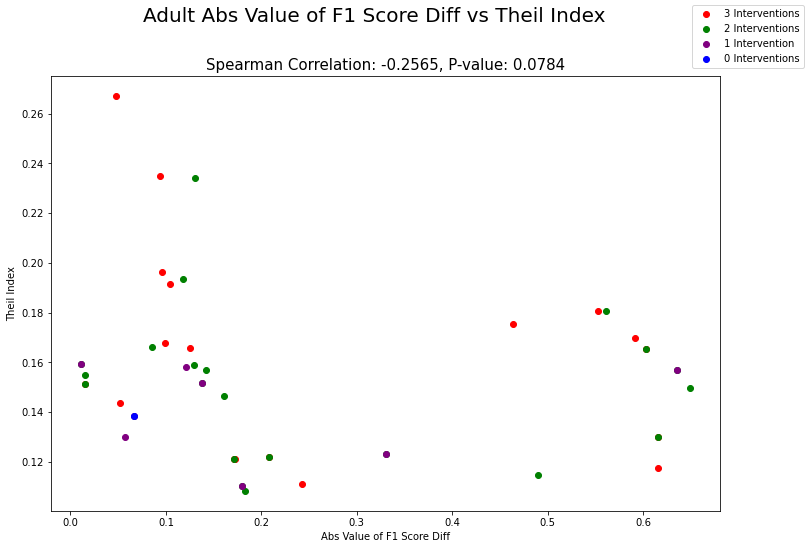

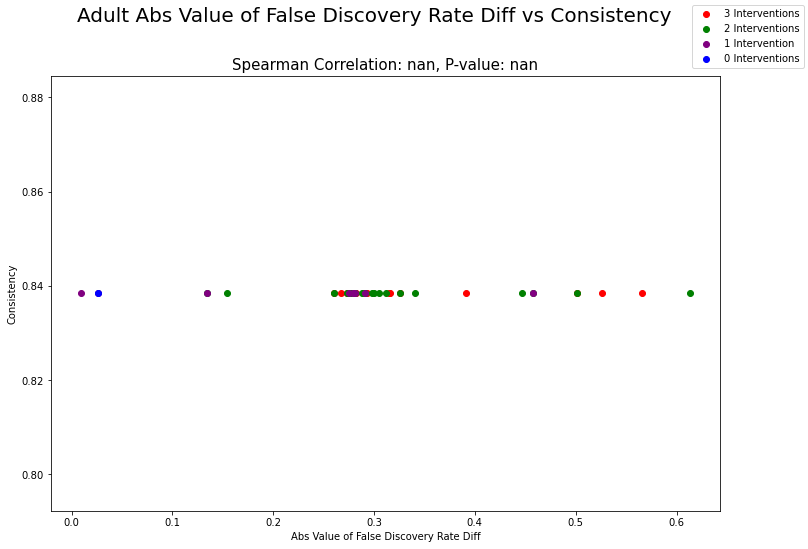

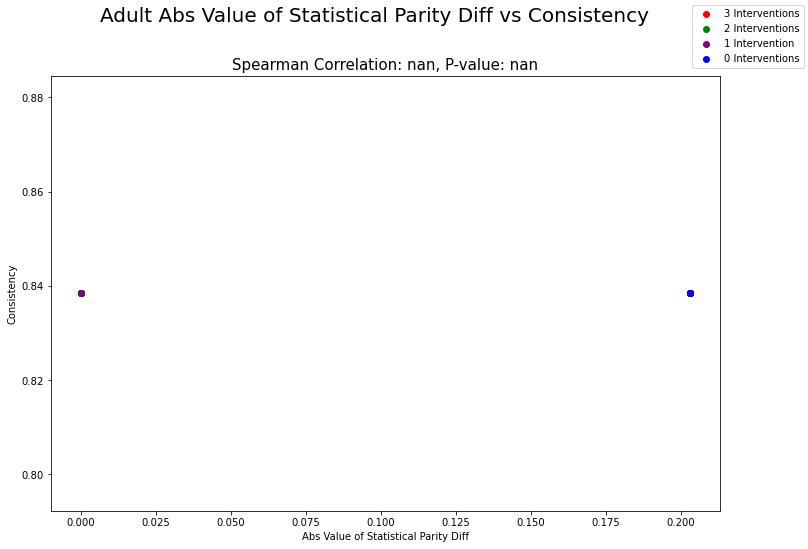

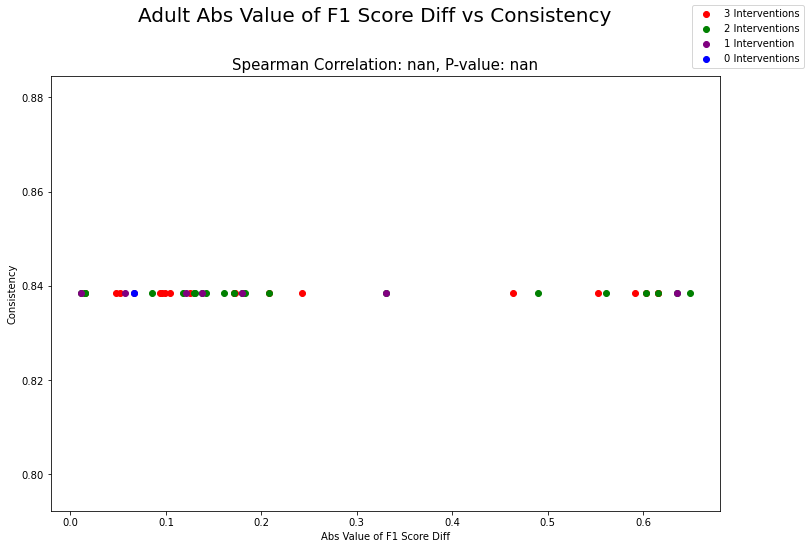

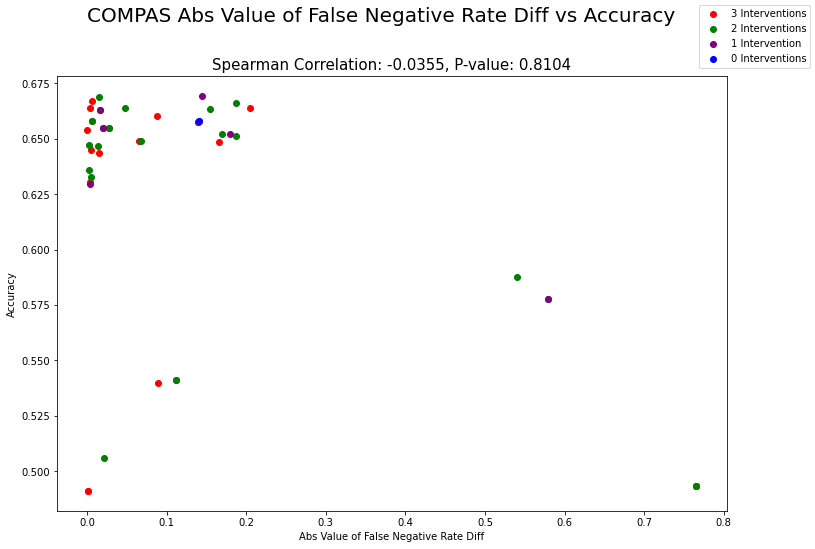

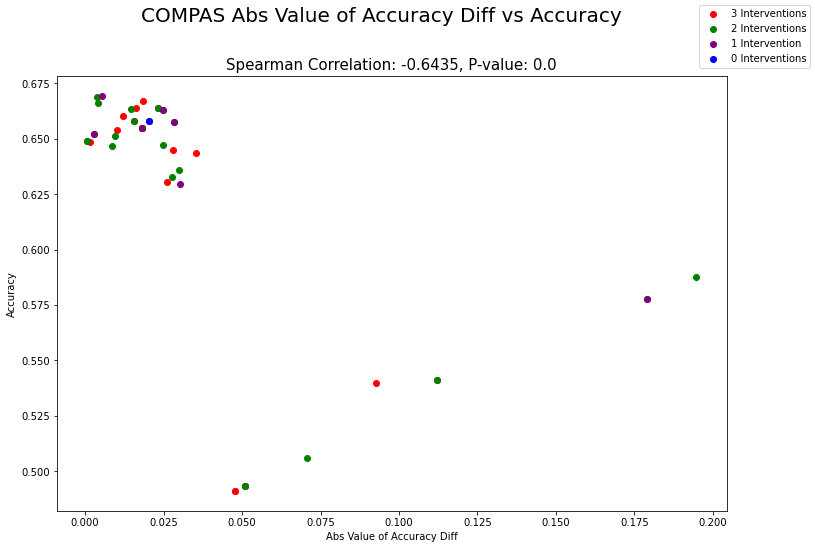

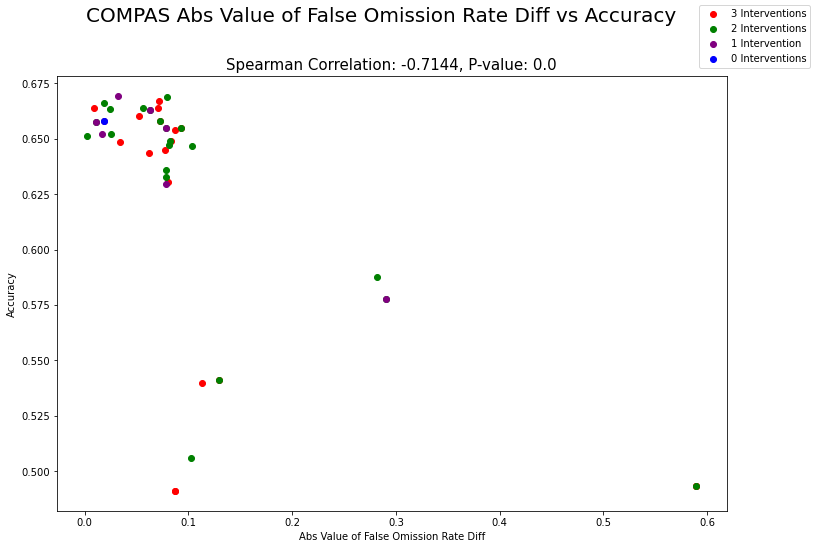

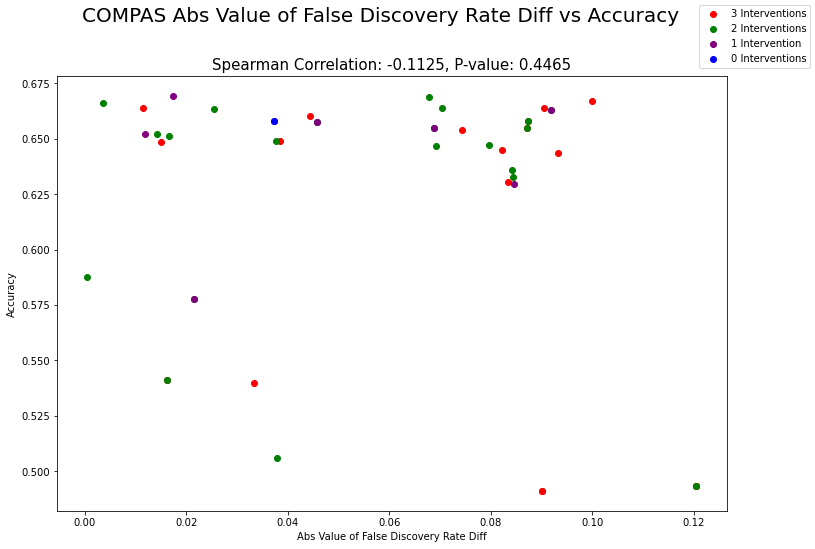

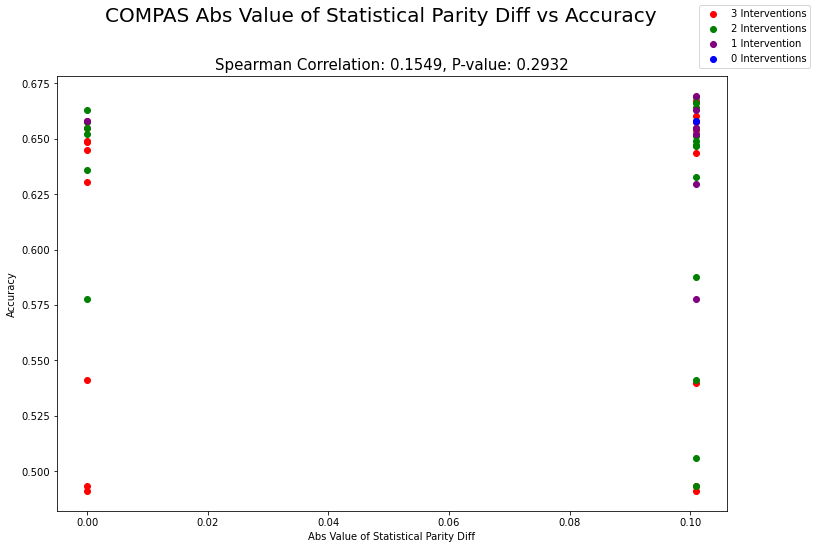

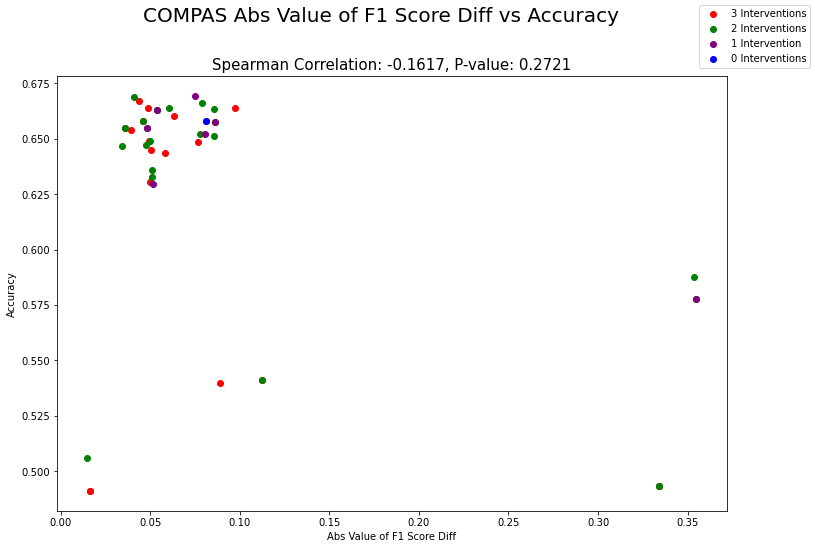

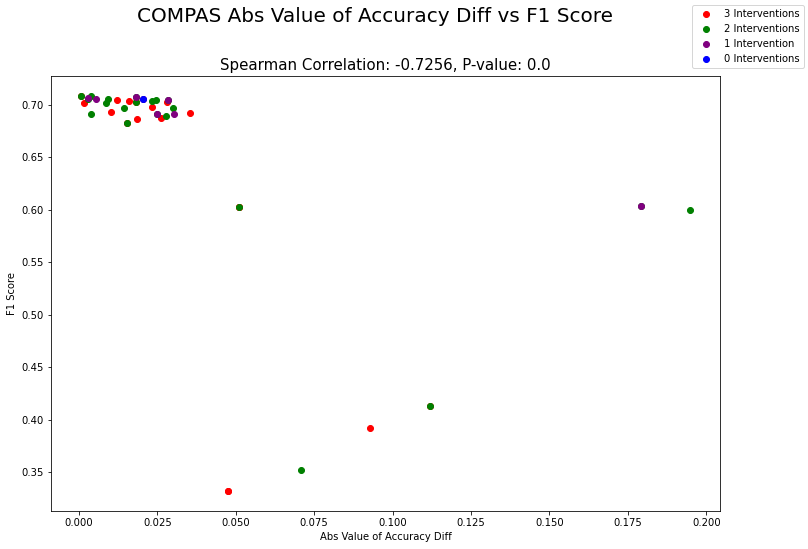

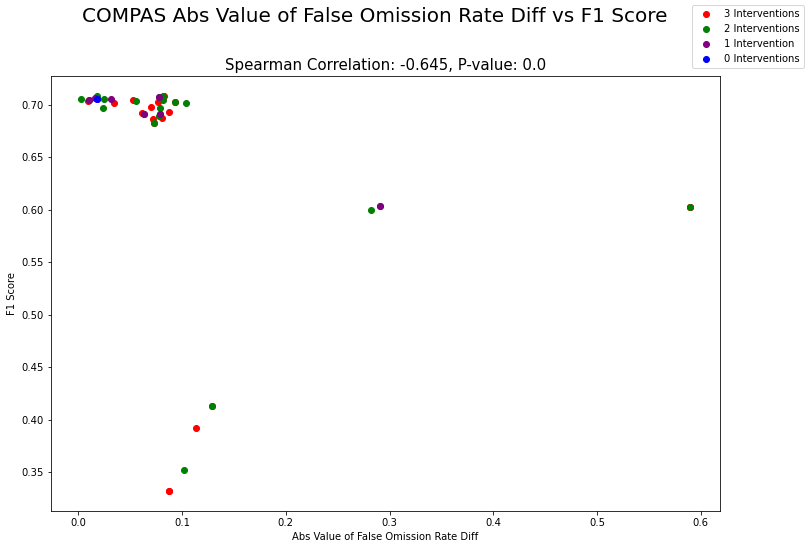

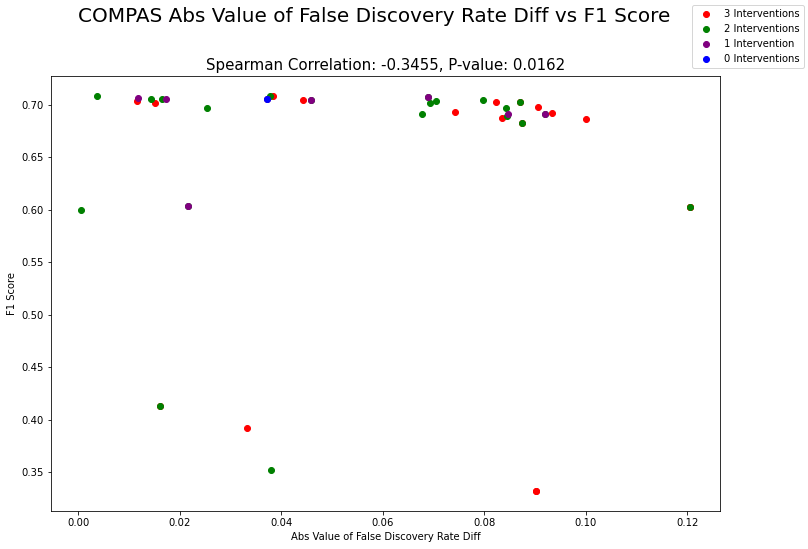

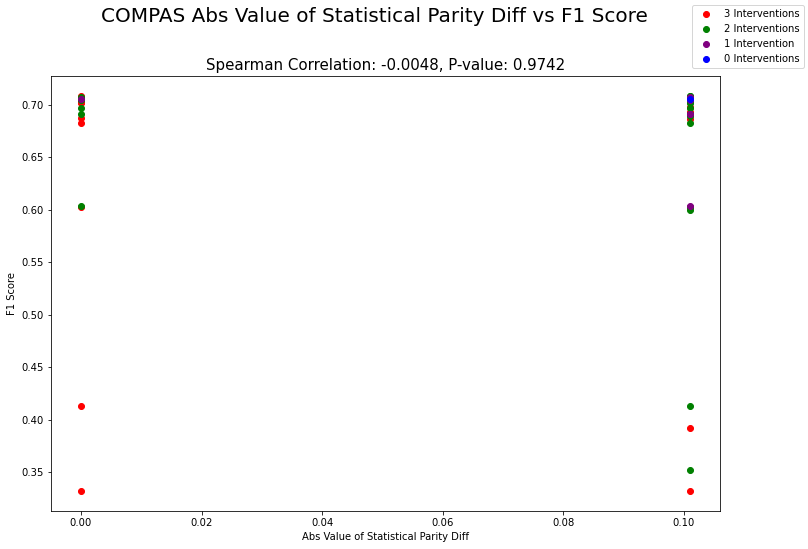

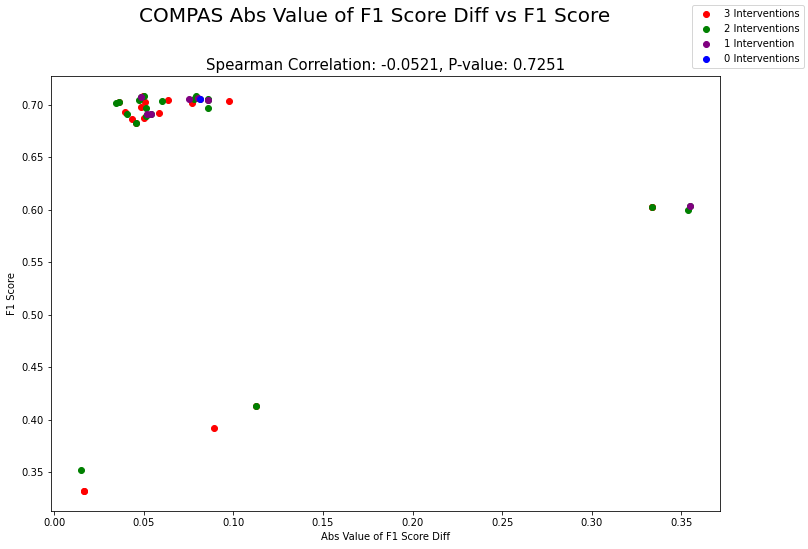

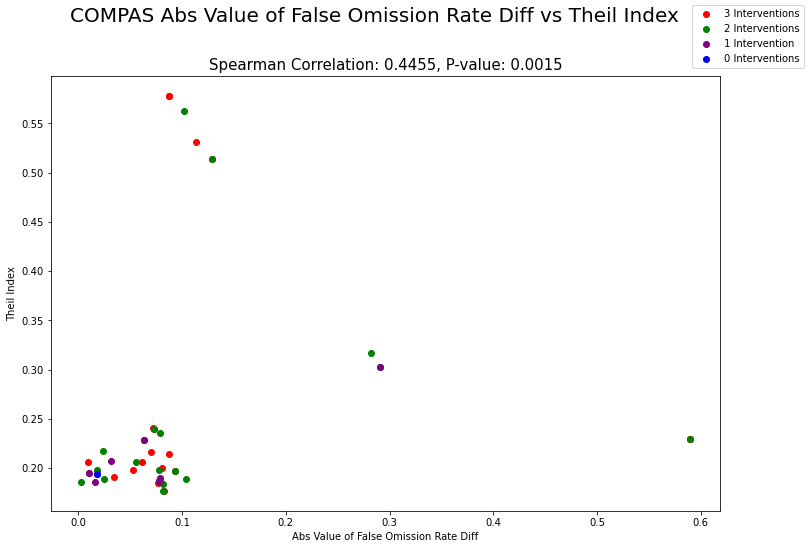

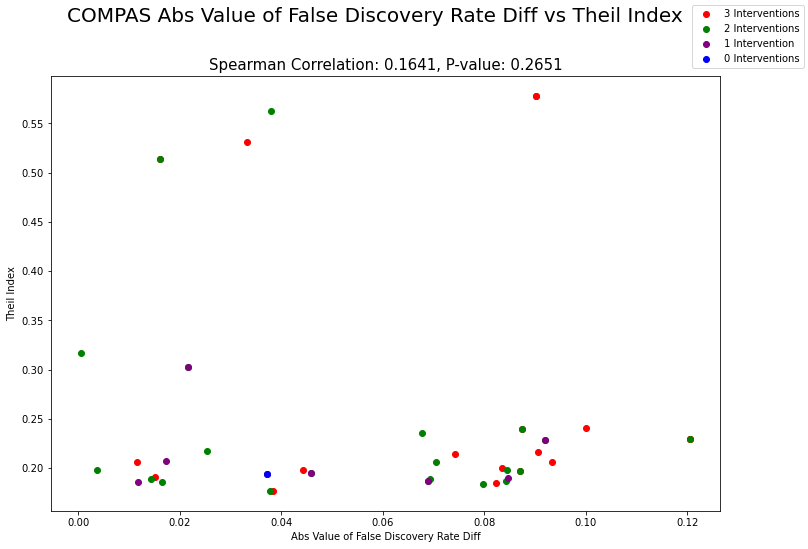

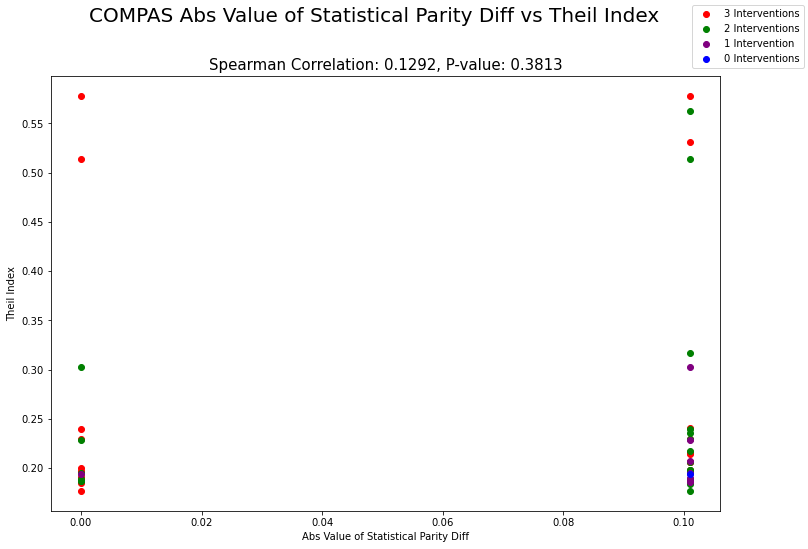

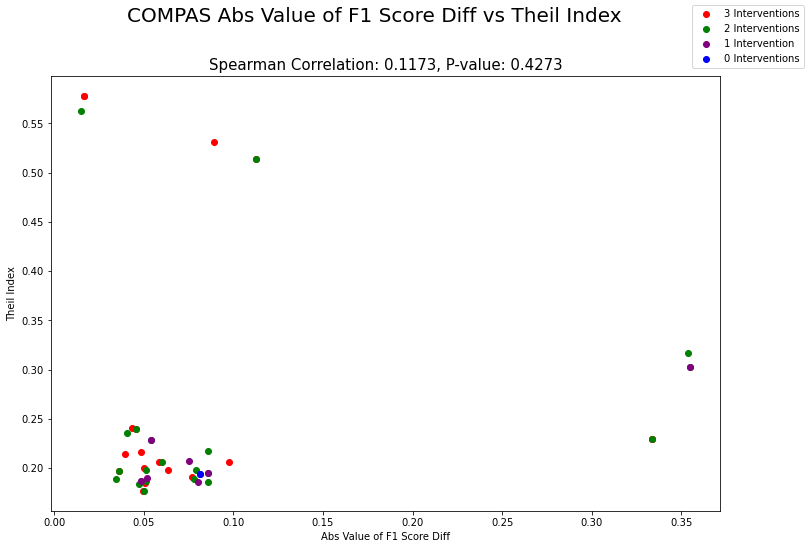

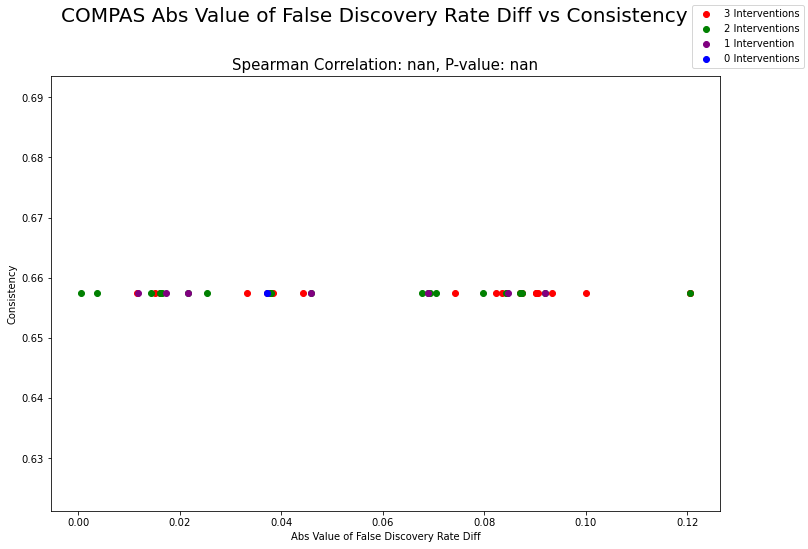

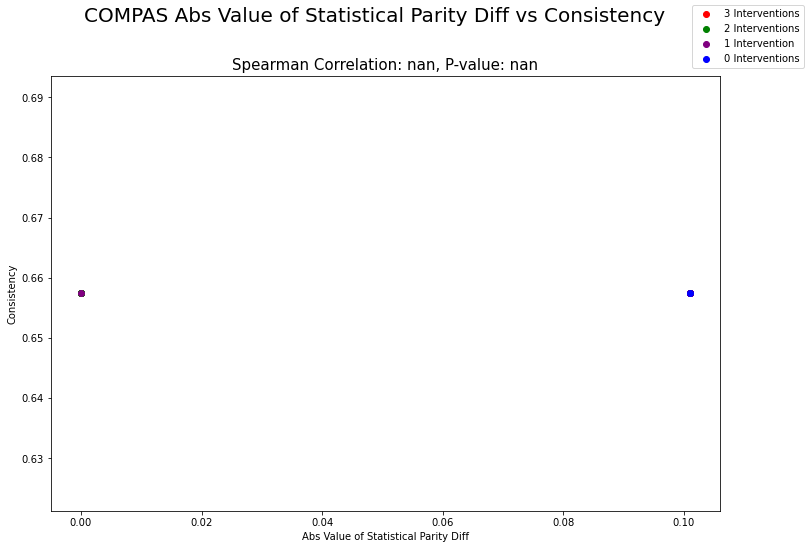

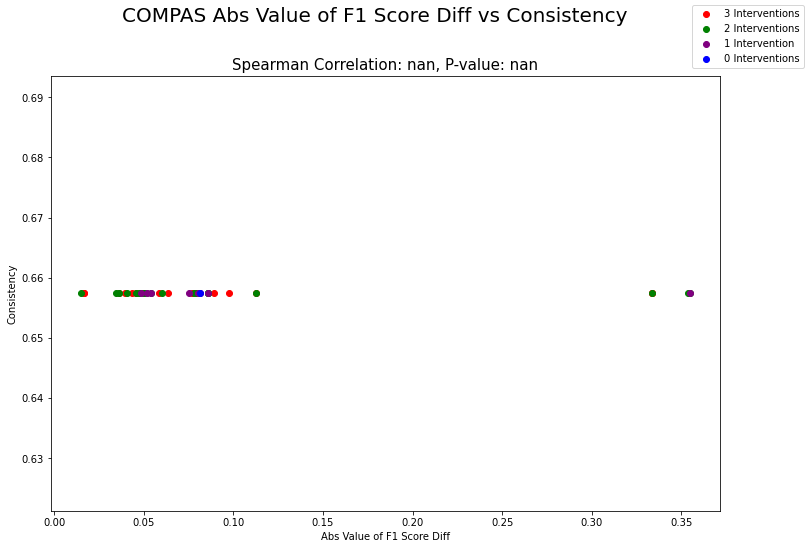

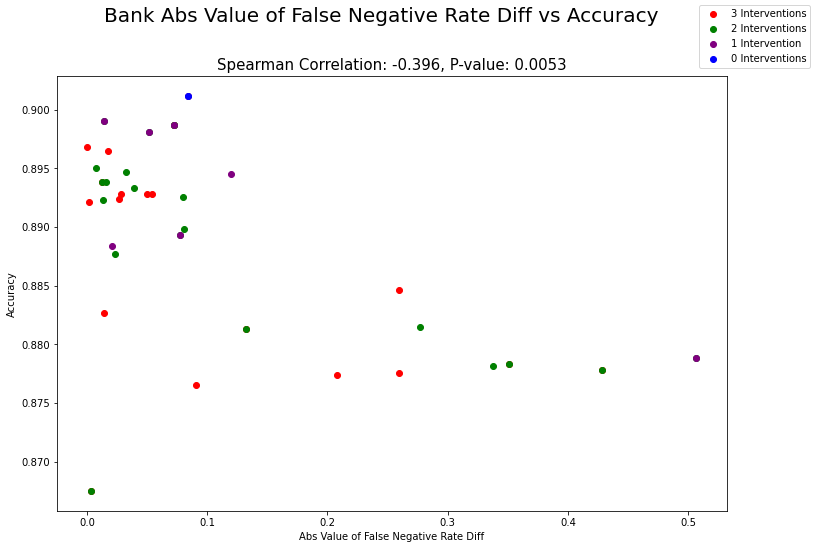

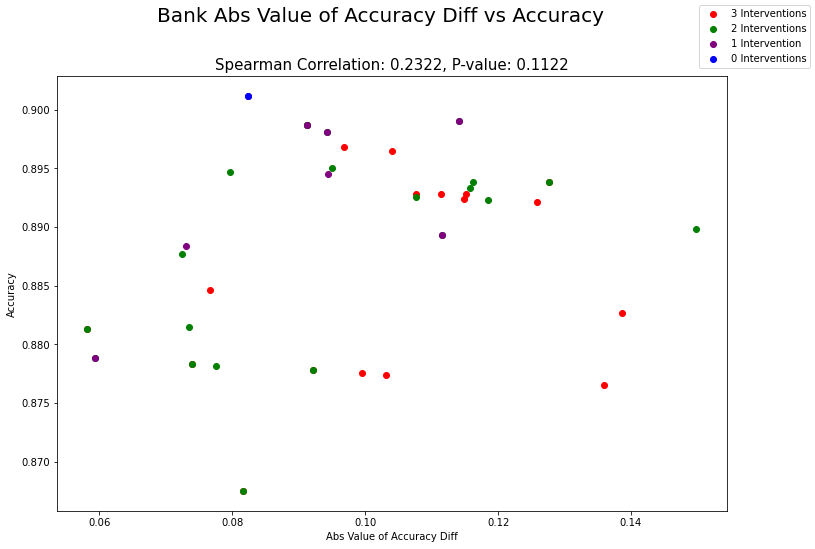

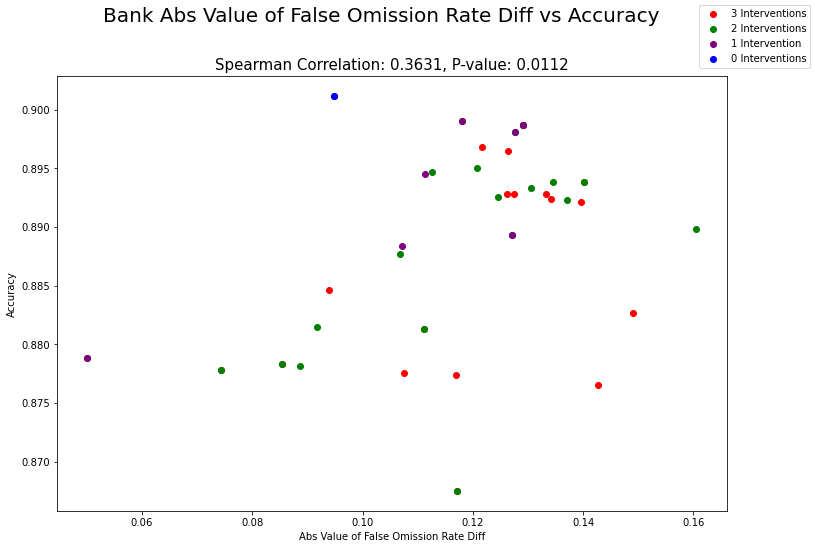

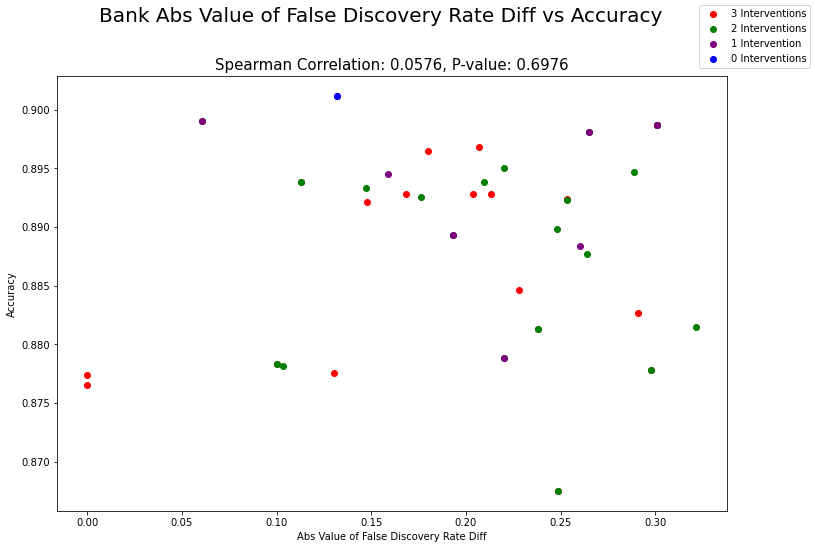

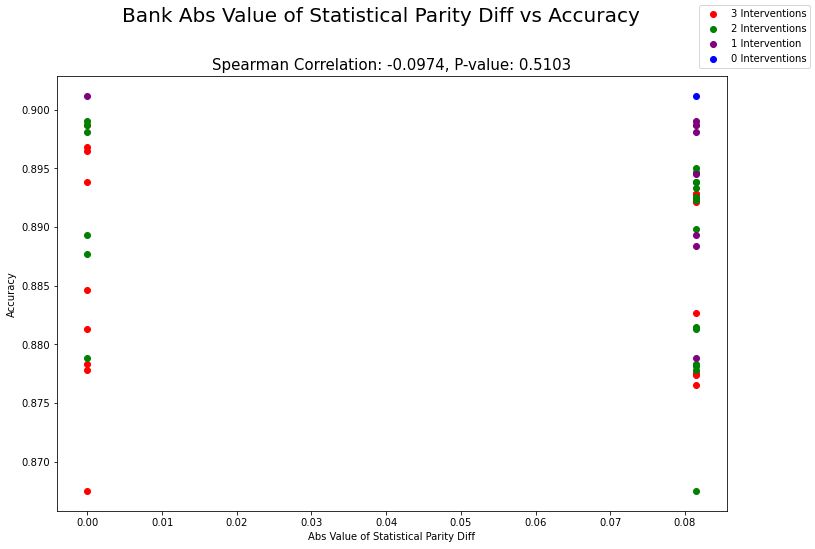

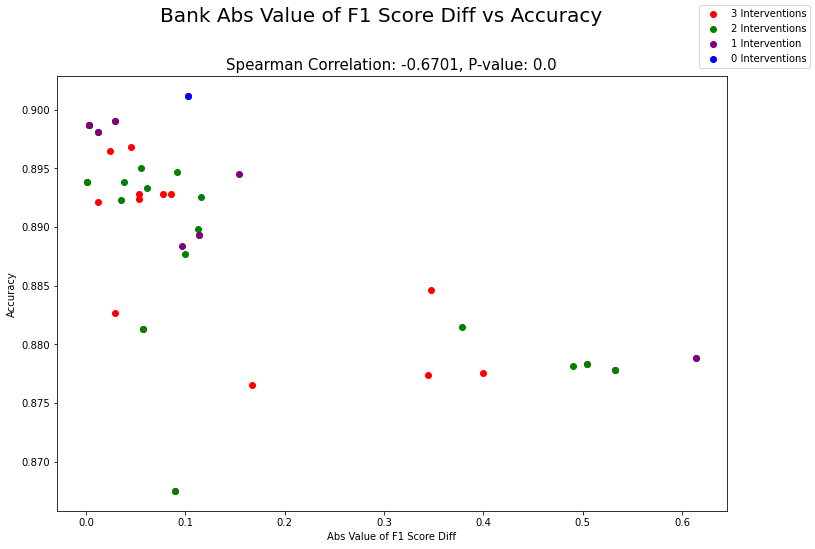

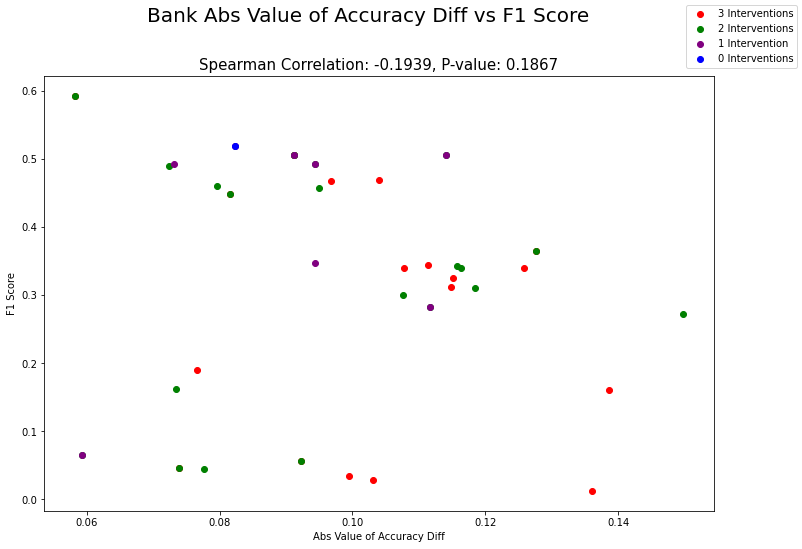

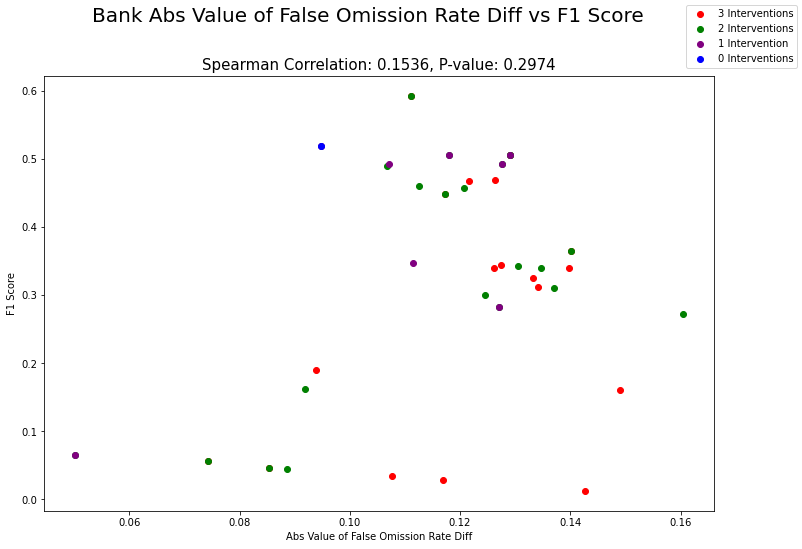

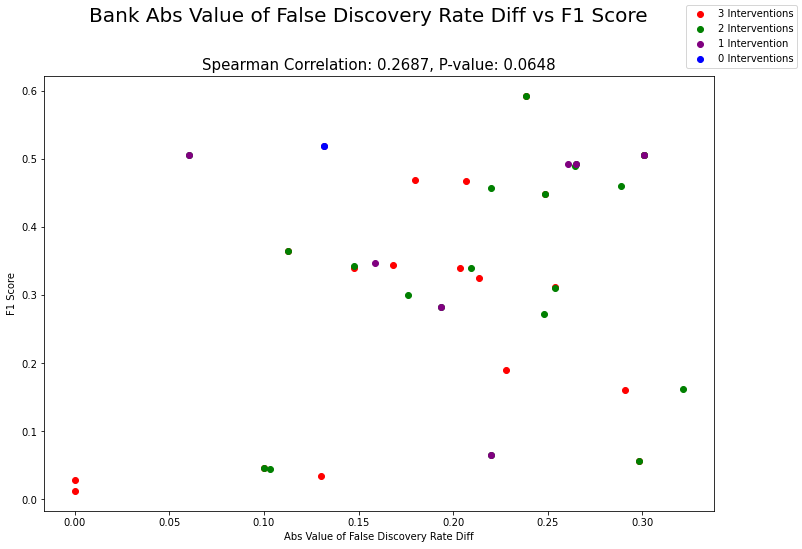

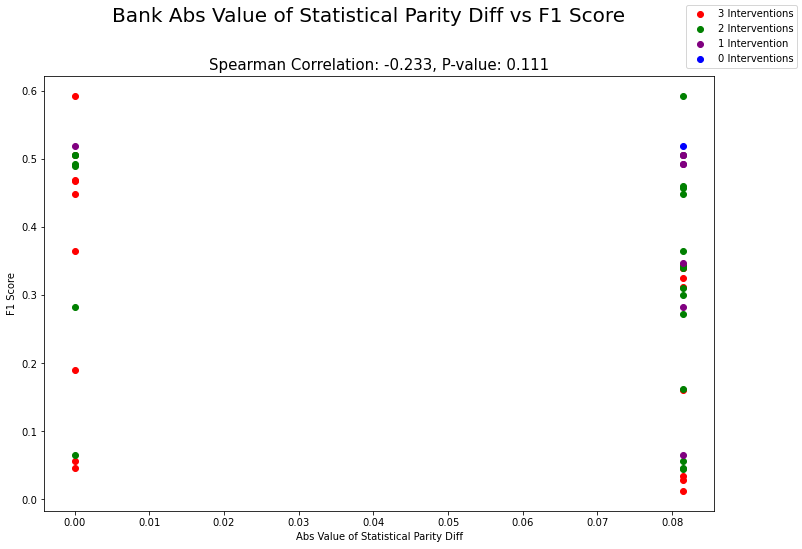

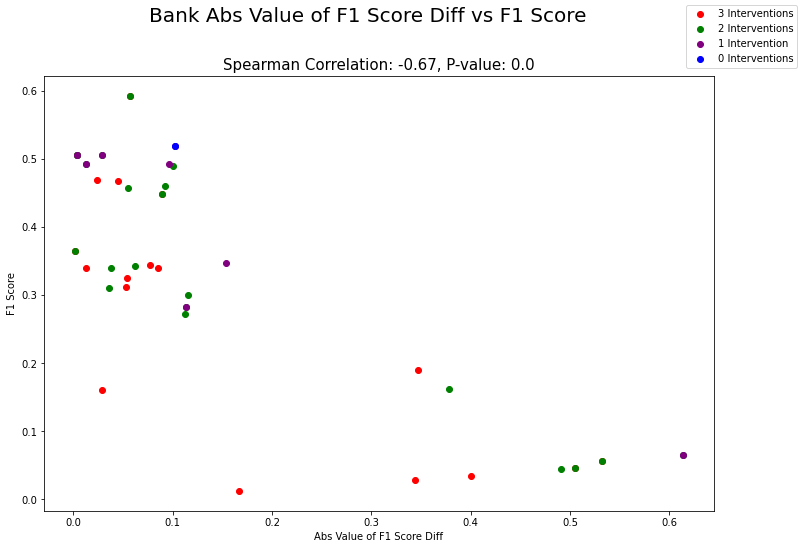

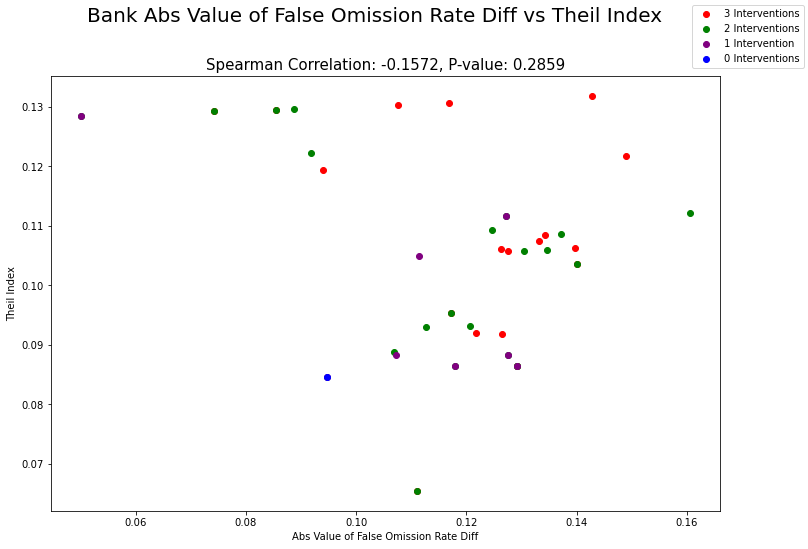

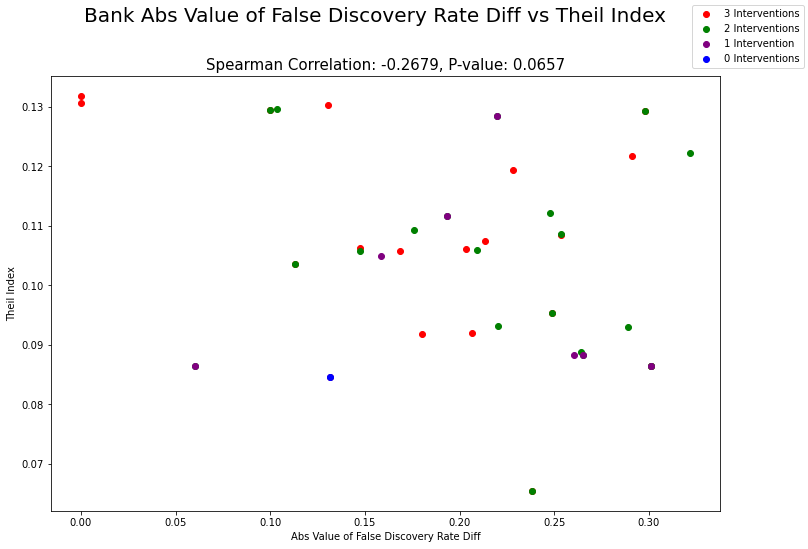

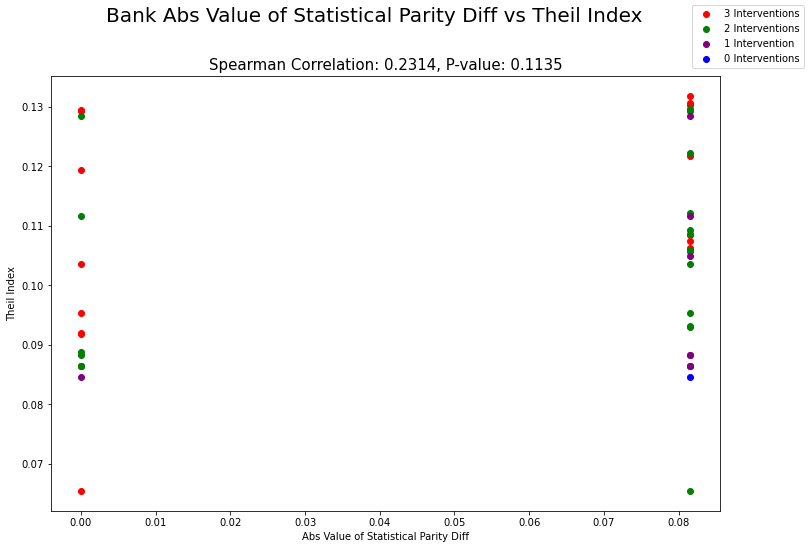

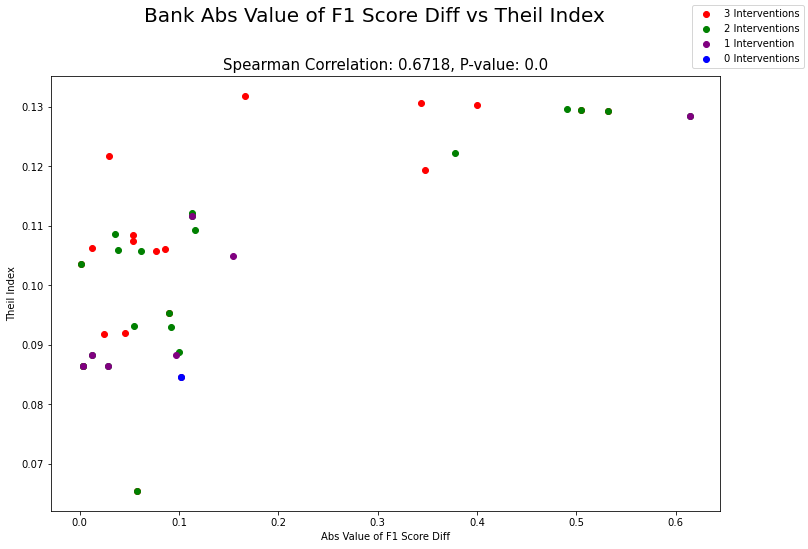

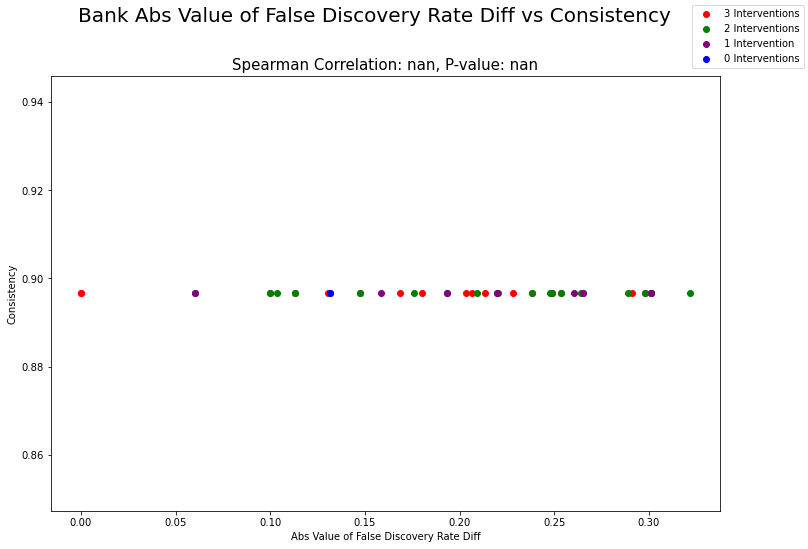

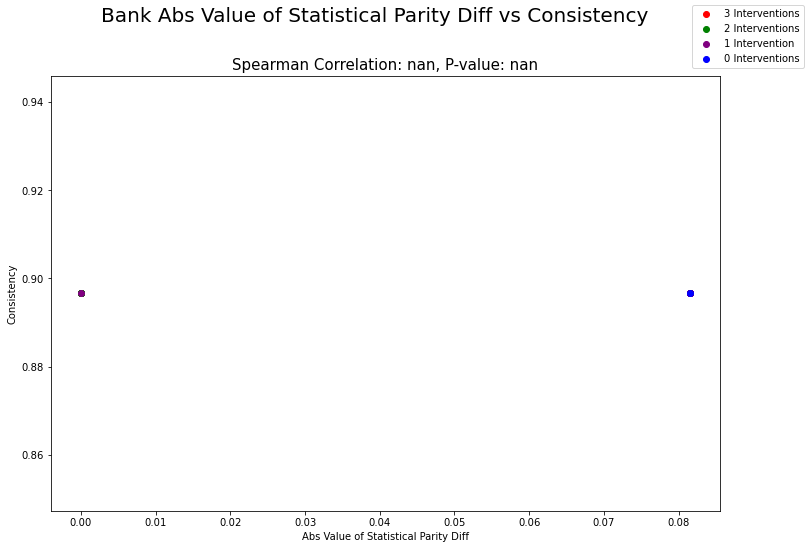

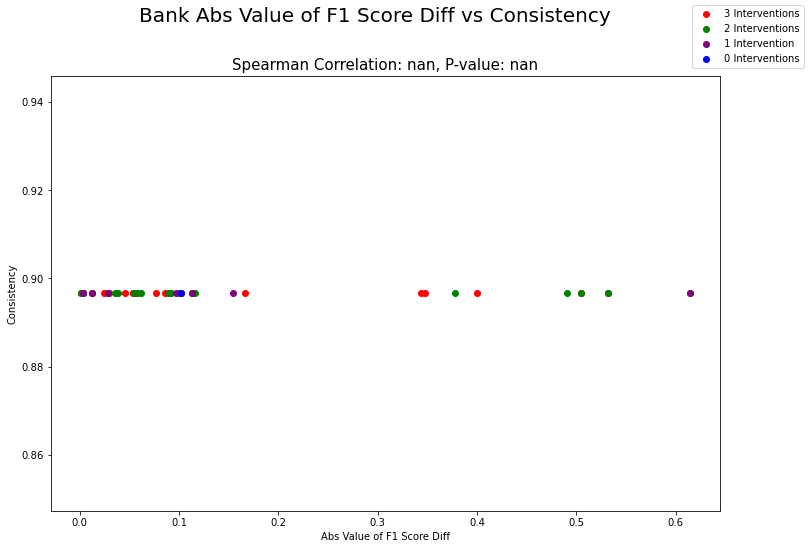

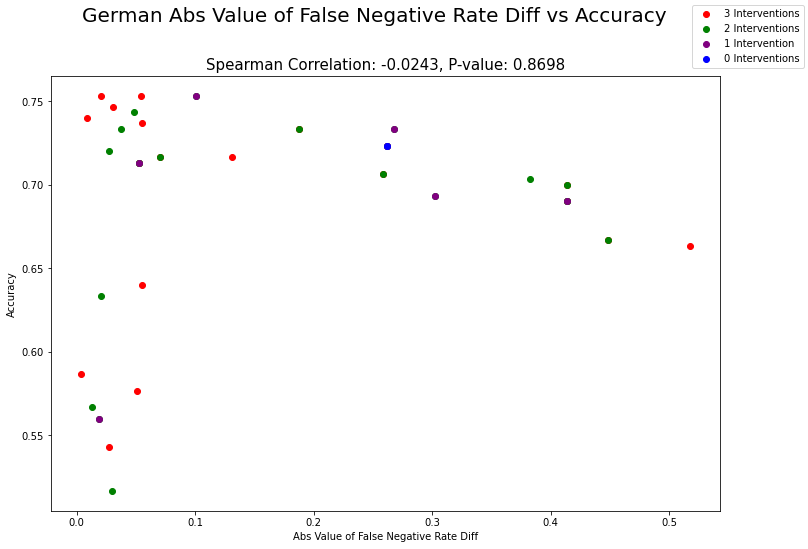

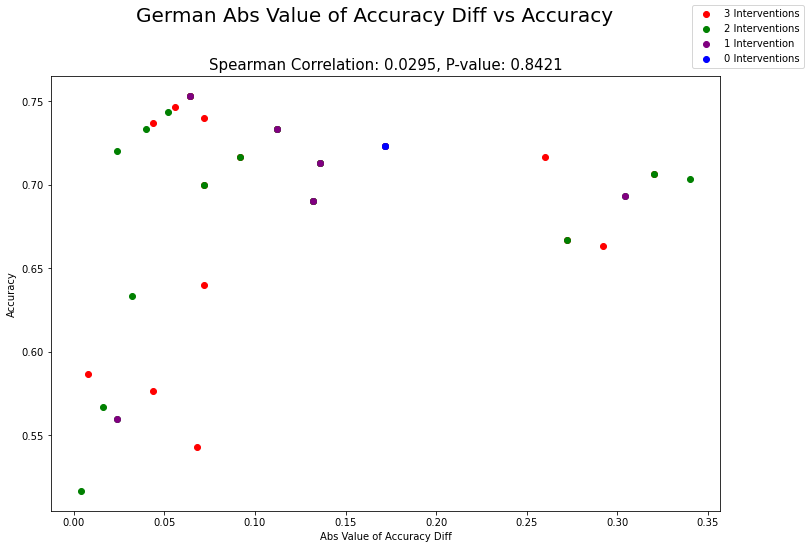

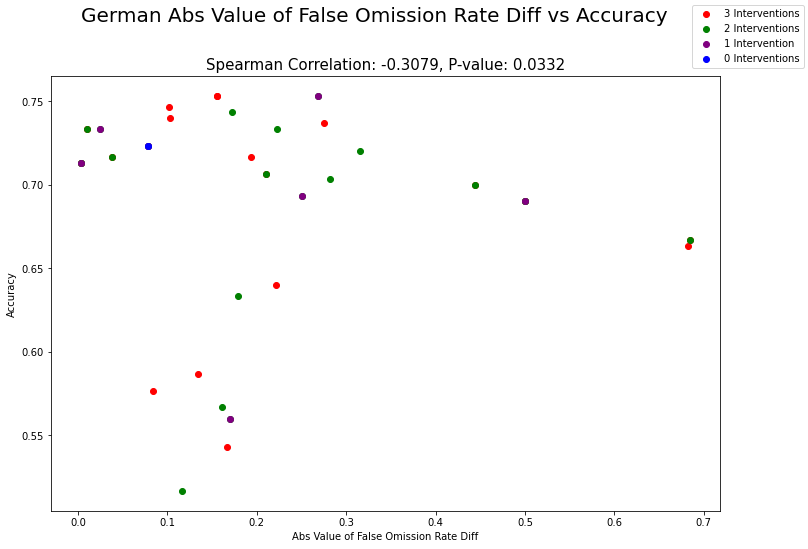

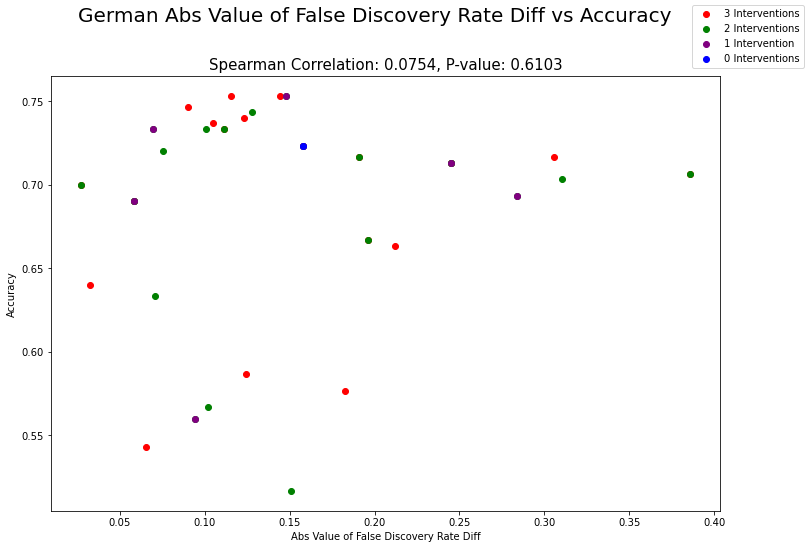

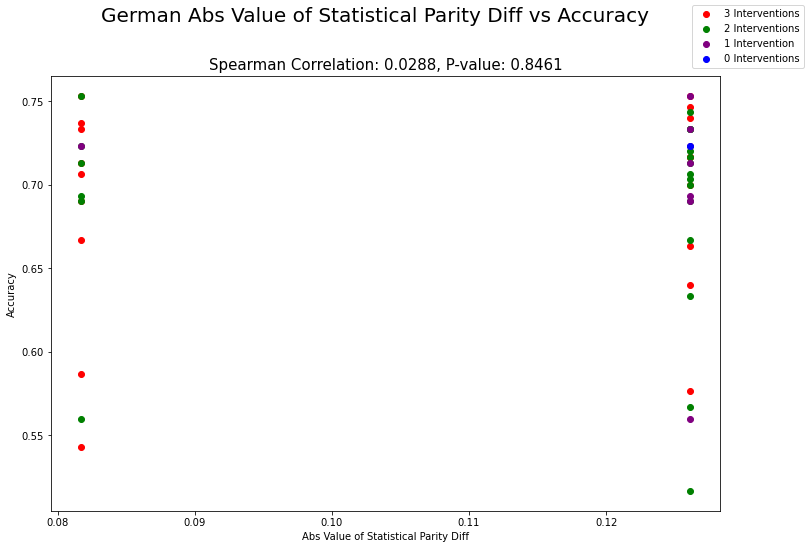

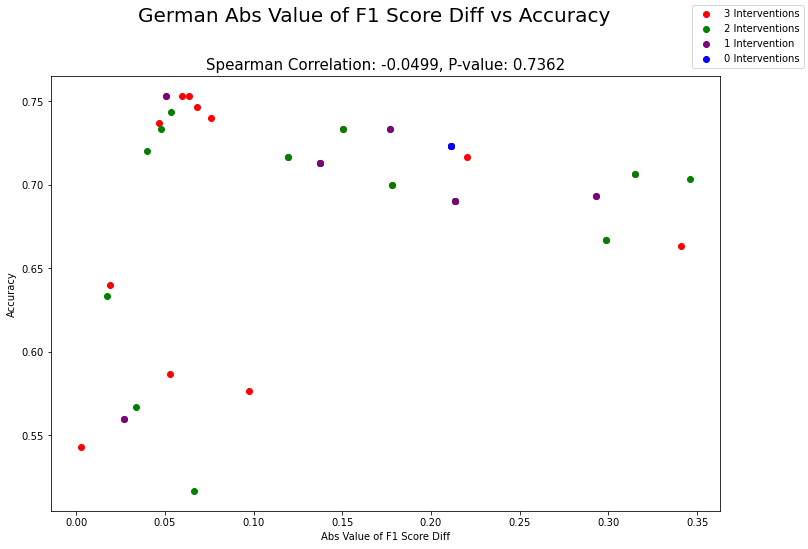

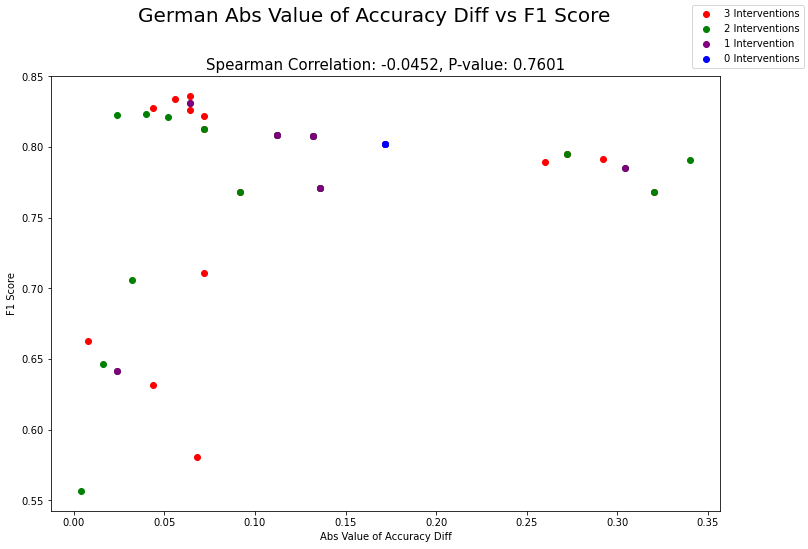

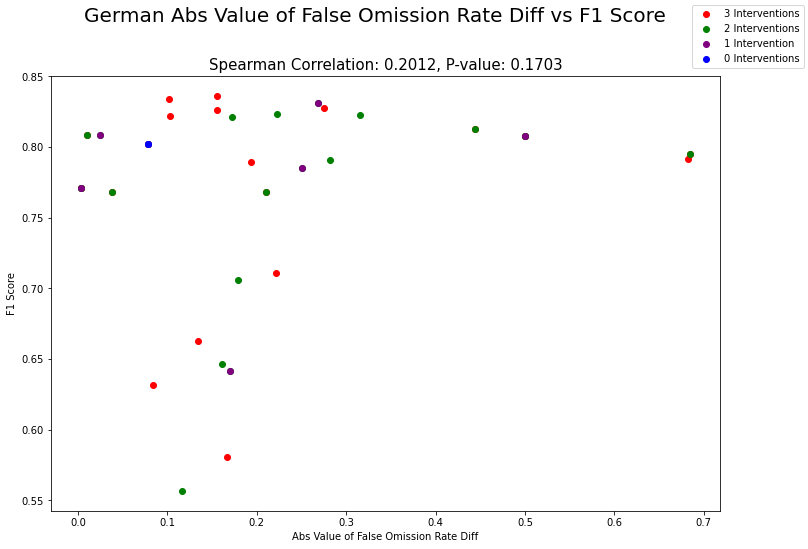

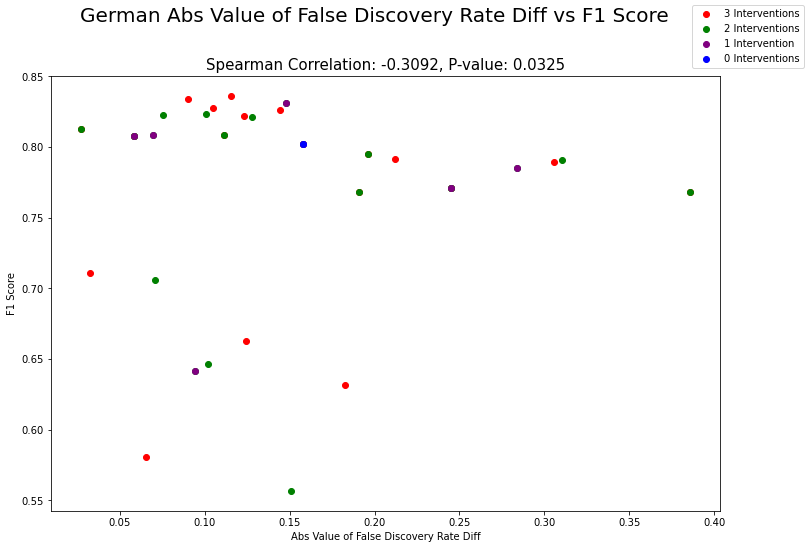

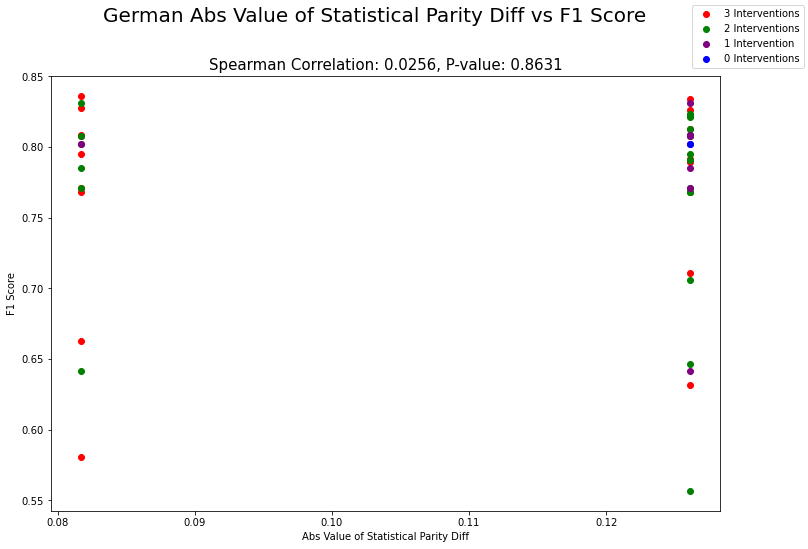

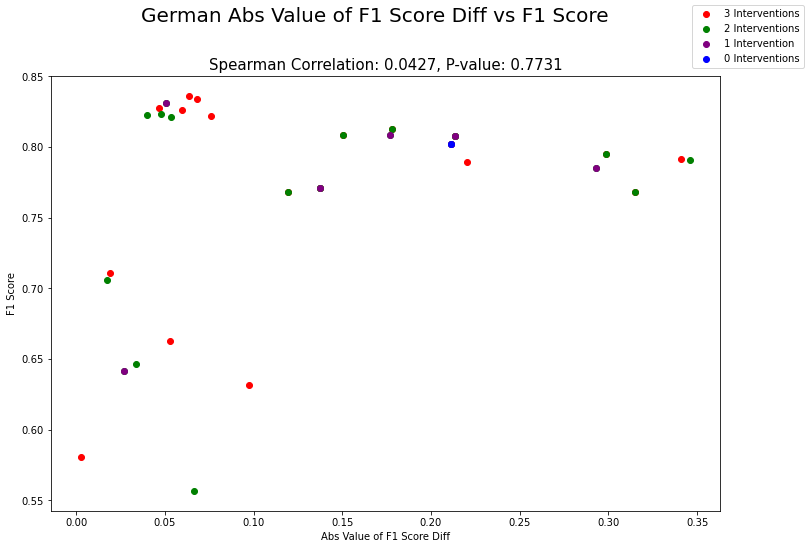

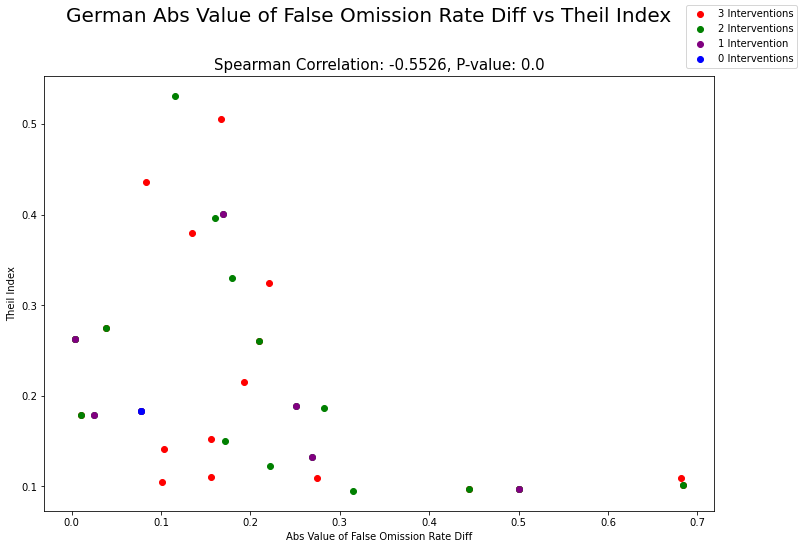

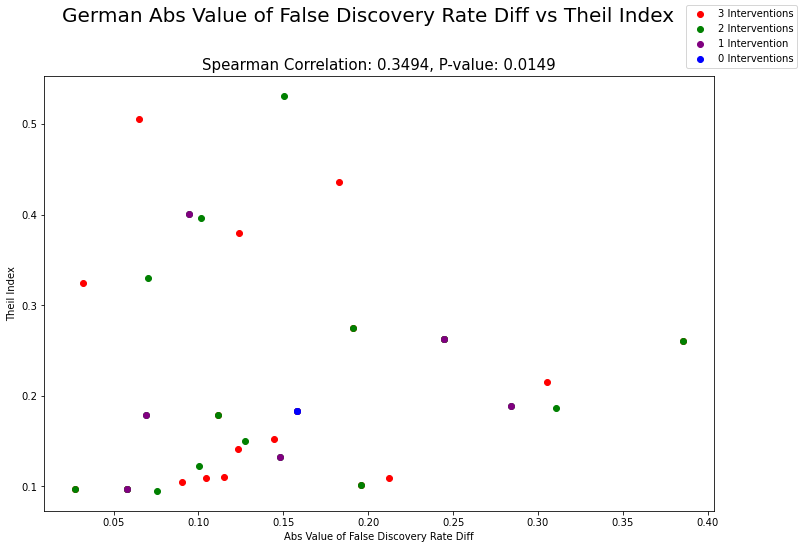

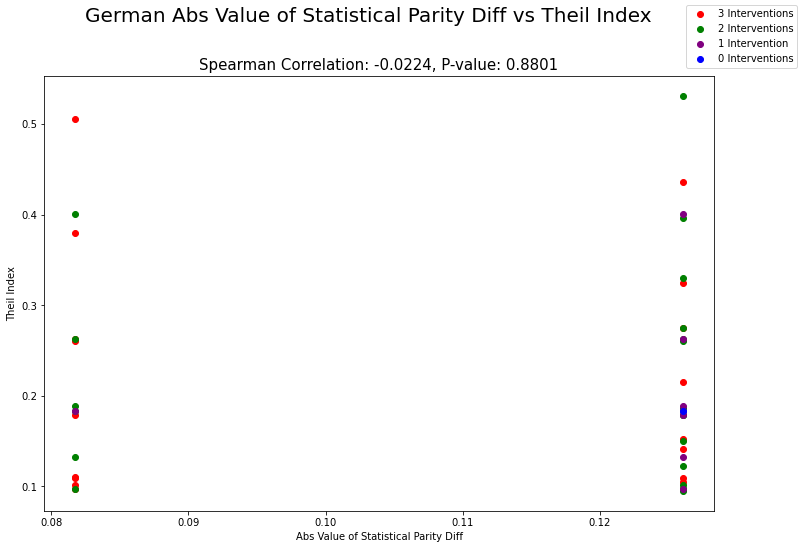

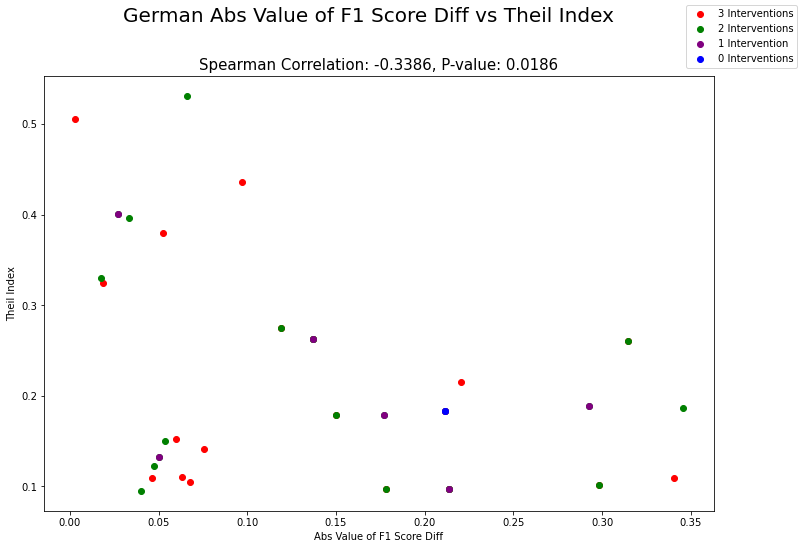

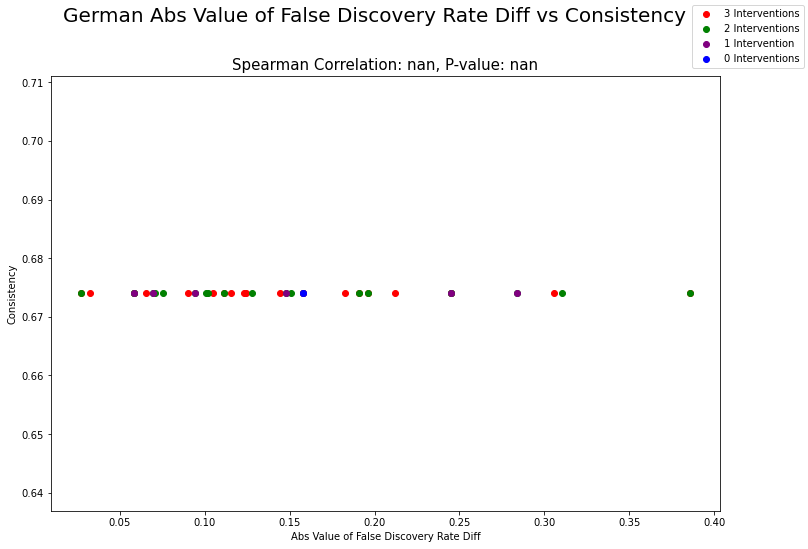

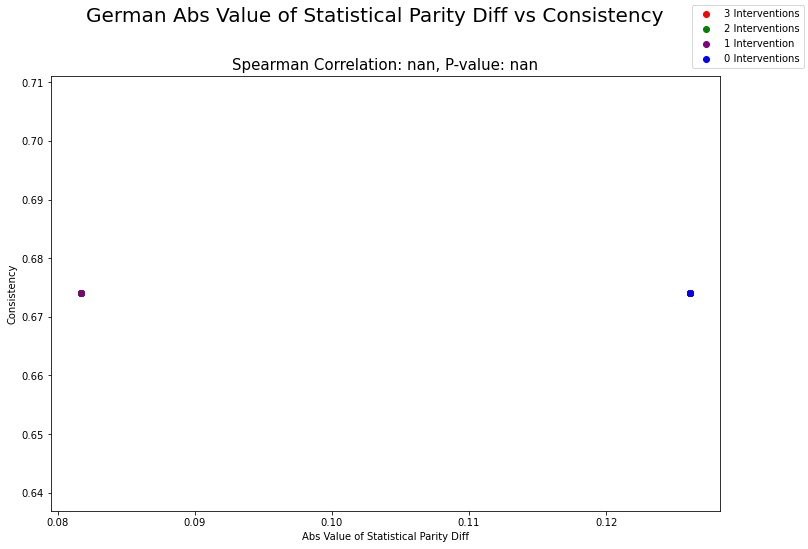

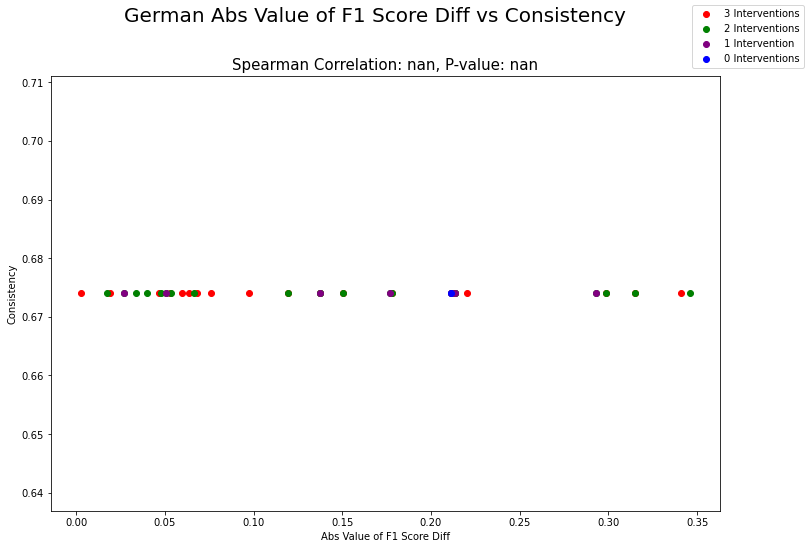

In [7]:
def display_scatter(x, y, df, df_name):
    x_diff = "Diff" in x
    y_diff = "Diff" in y
    
    spearman_x = np.array([])
    spearman_y = np.array([])
    
    fig = plt.figure(figsize=(12, 8))
    
    x4 = df.reindex(columns=[x], index=three_int)
    if x_diff:
        x4 = abs(x4)
    y4 = df.reindex(columns=[y], index=three_int)
    if x_diff:
        y4 = abs(y4)
    spearman_x = np.append(spearman_x, x4.to_numpy().flatten())
    spearman_y = np.append(spearman_y, y4.to_numpy().flatten())
    plt.scatter(x4, y4, c ="red", label="3 Interventions")

    x3 = df.reindex(columns=[x], index=two_int)
    if x_diff:
        x3 = abs(x3)
    y3 = df.reindex(columns=[y], index=two_int)
    if y_diff:
        y3 = abs(y3)
    spearman_x = np.append(spearman_x, x3.to_numpy().flatten())
    spearman_y = np.append(spearman_y, y3.to_numpy().flatten())
    plt.scatter(x3, y3, c ="green", label="2 Interventions")
    
    x2 = df.reindex(columns=[x], index=one_int)
    if x_diff:
        x2 = abs(x2)
    y2 = df.reindex(columns=[y], index=one_int)
    if y_diff:
        y2 = abs(y2)
    spearman_x = np.append(spearman_x, x2.to_numpy().flatten())
    spearman_y = np.append(spearman_y, y2.to_numpy().flatten())
    plt.scatter(x2, y2, c ="purple", label="1 Intervention")
            
    x1 = df.reindex(columns=[x], index=no_int)
    if x_diff:
        x1 = abs(x1)
    y1 = df.reindex(columns=[y], index=no_int)
    if y_diff:
        y1 = abs(y1)
    spearman_x = np.append(spearman_x, x1.to_numpy().flatten())
    spearman_y = np.append(spearman_y, y1.to_numpy().flatten())
    plt.scatter(x1, y1, c ="blue", label="0 Interventions",)
        #plt.axhline(y = y1.iloc[0,0].item(), color = 'blue', linestyle = 'dashed')
        #plt.axvline(x = x1.iloc[0,0].item(), color = 'blue', linestyle = 'dashed')
    #print(np.array(spearman_x).flatten())
    #print(np.array(spearman_y).flatten())
    
    spearman_corr, spearman_p = stats.spearmanr(spearman_x, spearman_y)
    #print(spearman_corr, spearman_p)

    if x_diff:
        x = "Abs Value of " + x
    
    if y_diff:
        y = "Abs Value of " + y
        
    plt.xlabel(x)
    plt.ylabel(y)
    fig.legend()
    fig.set_alpha(1.0)
    fig.patch.set_facecolor('white')
    plt.suptitle(f"{df_name} {x} vs {y}", y=1, fontsize=20)
    plt.title(f"Spearman Correlation: {round(spearman_corr,4)}, P-value: {round(spearman_p,4)}", fontsize=15)
    #plt.show()
    plt.savefig(f"R2/{df_name} {x} vs {y}.png", bbox_inches='tight', )
    
# cyan: 0 int'
# purple: 1 int'
# green: 2 int'
# red: 3 int'
#display_scatter("False Positive Rate Diff", "F1 Score")
'''for metric1 in range(1, len(adult_df.columns[1:])):
    if "Num" in adult_df.columns[metric1]:
        continue
    for metric2 in range(metric1+1, len(adult_df.columns[1:])):
        if "Num" in adult_df.columns[metric2]:
            continue
        display_scatter(adult_df.columns[metric1], adult_df.columns[metric2])'''
bias_metrics = [metric for metric in adult_df.columns if "Diff" in metric]
util_metrics = ["Accuracy", "F1 Score", "Theil Index", "Consistency"]
for m1 in range(len(util_metrics)):
    for m2 in range(m1+1, len(bias_metrics)):
        display_scatter(bias_metrics[m2], util_metrics[m1], adult_df, "Adult")
for m1 in range(len(util_metrics)):
    for m2 in range(m1+1, len(bias_metrics)):
        display_scatter(bias_metrics[m2], util_metrics[m1], compas_df, "COMPAS")
        
for m1 in range(len(util_metrics)):
    for m2 in range(m1+1, len(bias_metrics)):
        display_scatter(bias_metrics[m2], util_metrics[m1], bank_df, "Bank")
        
for m1 in range(len(util_metrics)):
    for m2 in range(m1+1, len(bias_metrics)):
        display_scatter(bias_metrics[m2], util_metrics[m1], german_df, "German")